<a href="https://colab.research.google.com/github/naphatsiri/M.Sc-IS-Fault-Detection/blob/main/IS_fault_detection_3models_4cri_161268_utd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.Data preparation

In [1]:
#Import working libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/normal%20r.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl10.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl20.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl30.xls
!wget https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/rl40.xls

--2025-12-16 06:46:49--  https://github.com/naphatsiri/M.Sc-IS-Fault-Detection/raw/main/Refrigerant-leak_data/normal%20r.xls
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/naphatsiri/M.Sc-IS-Fault-Detection/main/Refrigerant-leak_data/normal%20r.xls [following]
--2025-12-16 06:46:50--  https://raw.githubusercontent.com/naphatsiri/M.Sc-IS-Fault-Detection/main/Refrigerant-leak_data/normal%20r.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3102208 (3.0M) [application/octet-stream]
Saving to: ‘normal r.xls’

normal r.xls        100%[===================>]   2.96M  --.-KB/s    in 0.04s   

2025-1

In [3]:
#Use rl10%, rl20%, rl30%, rl40% and rl_normal dataset

df_normal = pd.read_excel("/content/normal r.xls", sheet_name="Reduced Data Set", engine='xlrd')
df_fault10 = pd.read_excel("/content/rl10.xls", sheet_name="Reduced Data Set", engine='xlrd')
df_fault20 = pd.read_excel("/content/rl20.xls", sheet_name="Reduced Data Set", engine='xlrd')
df_fault30 = pd.read_excel("/content/rl30.xls", sheet_name="Reduced Data Set", engine='xlrd')
df_fault40 = pd.read_excel("/content/rl40.xls", sheet_name="Reduced Data Set", engine='xlrd')

In [4]:
df_normal.info()
df_fault10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time (minutes)       433 non-null    float64
 1   TWE_set              433 non-null    int64  
 2   TEI                  433 non-null    float64
 3   TWEI                 433 non-null    float64
 4   TEO                  433 non-null    float64
 5   TWEO                 433 non-null    float64
 6   TCI                  433 non-null    float64
 7   TWCI                 433 non-null    float64
 8   TCO                  433 non-null    float64
 9   TWCO                 433 non-null    float64
 10  TSI                  433 non-null    float64
 11  TSO                  433 non-null    float64
 12  TBI                  433 non-null    float64
 13  TBO                  433 non-null    float64
 14  Cond Tons            433 non-null    float64
 15  Cooling Tons         433 non-null    flo

## 1.Normal vs 10% less than nominal

In [4]:
df_normal["label"] = 0
df_fault10["label"] = 1

df10 = pd.concat([df_normal, df_fault10], ignore_index=True)

In [5]:
df10.shape

(866, 67)

In [6]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Keep only rows where the unit is operating
# what is unit status ?

'''df = df[df["Unit Status"] == 1]'''

# Only remove *obviously invalid* rows
df10 = df10[(df10["Cooling Tons"] >= 0) & (df10["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df10[col].quantile([0.001, 0.999])
    df10[col] = df10[col].clip(lower, upper)

print("Cleaned data shape:", df10.shape)



Cleaned data shape: (866, 67)


In [7]:
df10.head()

,Time (minutes),TWE_set,TEI,TWEI,TEO,TWEO,TCI,TWCI,TCO,TWCO,...,VE,VW,TWI,TWO,THI,THO,FWW,FWH,FWB,label
0,0.0612,50,65.59,65.6,66.40,66.4,67.44,67.3,68.50,68.4,...,56,0.0,66.21,71.01,67.54,70.72,2.202000e-47,5.491000e-46,3.853000e-45,0
1,2.0600,50,67.23,67.6,67.26,67.3,67.56,67.3,67.76,67.3,...,56,30.0,63.67,66.35,67.83,67.73,1.527000e+01,5.041000e+01,2.698000e+02,0
2,4.0600,50,67.64,67.8,67.59,67.5,67.31,67.0,67.47,67.3,...,56,30.0,62.03,65.49,67.91,67.81,2.146000e+01,2.438000e+01,2.693000e+02,0
3,6.0600,50,67.44,67.3,67.42,67.3,66.86,66.5,67.07,66.7,...,56,30.0,59.74,63.89,67.70,67.60,2.589000e+01,2.442000e+01,2.603000e+02,0
4,8.0600,49,66.66,66.2,64.92,63.7,67.76,68.4,69.89,71.4,...,56,20.0,59.17,64.75,66.80,66.79,5.489000e+01,2.461000e+01,-8.491000e+01,0


In [8]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

df10 = df10[["Time (minutes)"] + selected_features + ["label"]]
print("Final feature set:", df10.shape)


Final feature set: (866, 21)


In [9]:
df10.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,0.0,1.682000e-45,3.649000e-46,2.722816e-47,0,0,16.1,6.4,1.682000e-45,0
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,0.0,1.682000e-45,8.203000e-01,1.701000e+00,0,0,16.4,5.7,1.682000e-45,0
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,0.0,1.682000e-45,1.764000e+00,3.087000e+00,0,0,15.3,6.0,1.682000e-45,0
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,0.0,1.682000e-45,4.665000e-01,4.474000e+00,0,0,13.3,7.3,1.682000e-45,0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,18.7,3.601000e+01,1.539000e+00,1.276000e+01,43,41,7.1,33.6,2.284000e+00,0


In [ ]:
#To confirm that there is no missing value.

print(df10.isna().sum())

Time (minutes)    0
TEI               0
TEO               0
TWI               0
TWO               0
TCI               0
TCO               0
TWCI              0
TWCO              0
PRE               0
PRC               0
P_lift            0
kW                0
COP               0
Cooling Tons      0
Amps              0
RLA%              0
Tsh_suc           0
Tsh_dis           0
kW/Ton            0
label             0
dtype: int64


### 1.1 Features engineering operation

In [10]:
# Derived temperature features

# Evaporator and condenser approach temperatures
df10["Evap_Approach"] = df10["TEO"] - df10["TEI"]        # Evaporator approach (ΔT across evaporator)
df10["Cond_Approach"] = df10["TCO"] - df10["TCI"]        # Condenser approach (ΔT across condenser)

# Temperature lift: overall temperature difference between condenser and evaporator
df10["Temp_Lift"] = df10["TCO"] - df10["TEO"]

# Pressure-based features
df10["Pressure_Ratio"] = df10["PRC"] / df10["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df10["kW_per_Ton"] = df10["kW"] / df10["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df10["Delta_Superheat"] = df10["Tsh_suc"] - df10["Tsh_dis"]


In [11]:
df10.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Evap_Approach,Cond_Approach,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.177428e+01,9.7
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,16.4,5.7,1.682000e-45,0,0.03,0.20,0.50,1.000000,9.888301e-46,10.7
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,15.3,6.0,1.682000e-45,0,-0.05,0.16,-0.12,1.000000,5.448656e-46,9.3
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,13.3,7.3,1.682000e-45,0,-0.02,0.21,-0.35,0.989505,3.759499e-46,6.0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,7.1,33.6,2.284000e+00,0,-1.74,2.13,4.97,1.346499,2.822100e+00,-26.5


In [12]:
# Create Rolling (Time-Series) Features
''' Rolling time-series features were generated to capture the temporal behavior of chiller operation,
as refrigerant leakage and performance degradation develop gradually rather than instantaneously'''

# Define columns to create rolling stats for
'''Although temperature measurements are fundamental indicators of chiller operation,
this study emphasizes performance- and pressure-based features such as COP, kW, Cooling Tons, PRE, and PRC.
These variables integrate temperature effects with system load and refrigerant-side thermodynamics,'''

rolling_cols = ["COP", "kW", "Cooling Tons", "PRE", "PRC"]

# Create rolling mean and standard deviation (window ~6 samples ≈ 1 min)
for col in rolling_cols:
    df10[f"{col}_mean"] = df10[col].rolling(window=6, min_periods=1).mean()
    df10[f"{col}_std"] = df10[col].rolling(window=6, min_periods=1).std()


In [13]:
df10.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,3.649000e-46,NaN,1.682000e-45,NaN,2.722816e-47,NaN,66.100000,NaN,66.000000,NaN
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.800000,0.989949,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.866667,0.709460,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.825000,0.585235,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.600000,5.001000,68.300000,3.801316


In [15]:
df10.shape

(866, 37)

In [16]:
# Final features of operational data.

feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Evap_Approach", "Cond_Approach", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat",

    # Rolling features
    "COP_mean", "COP_std", "kW_mean", "kW_std",
    "PRE_mean", "PRE_std", "PRC_mean", "PRC_std"
]

# Fill missing values safely before dropping
df10[feature_cols] = df10[feature_cols].replace([np.inf, -np.inf], np.nan)
df10[feature_cols] = df10[feature_cols].fillna(df10[feature_cols].median())

# Drop any NaN rows created by rolling calculations
df10 = df10.dropna(subset=feature_cols)

print("Final feature matrix shape:", df10[feature_cols].shape)


Final feature matrix shape: (866, 31)


In [17]:
df10.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,3.649000e-46,0.102191,1.682000e-45,1.997395,2.722816e-47,NaN,66.100000,0.348807,66.000000,1.356466
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.800000,0.989949,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.866667,0.709460,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.825000,0.585235,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.600000,5.001000,68.300000,3.801316


In [18]:
print("Label distribution:")
print(df10["label"].value_counts())


Label distribution:
label
0    433
1    433
Name: count, dtype: int64


### 1.2 ML model operation

In [19]:
#Install optuna (for hyperparameter tuning)

!pip install optuna xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [20]:
#Import working libraries.
#Including optuna for hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [21]:
# Separate features and label
X_df10 = df10.drop(columns=["Time (minutes)", "label"])
y10 = df10["label"]

# Standardize features
scaler = StandardScaler()
X_scaled_array10 = scaler.fit_transform(X_df10)

# Convert scaled array back to DataFrame with original column names
X_scaled_df10 = pd.DataFrame(X_scaled_array10, columns=X_df10.columns)

In [22]:
# Train-Test-Split

X_tr10, X_te10, y_tr10, y_te10 = train_test_split(
    X_scaled_df10, y10, test_size=0.2, stratify=y10, random_state=42
)

print("Train size:", X_tr10.shape)
print("Test size:", X_te10.shape)

Train size: (692, 35)
Test size: (174, 35)


In [23]:
#Data split and shared setting

# Cross-validation (CV) setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr10)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr10)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr10==0).sum()
pos_count = (y_tr10==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [24]:
#Shared cross-validation evaluation helper

def cv_score_estimator10(estimator, X, y, cv, early_stopping=True, model_name="model"):
    f1_scores, rec_scores, auc_scores = [], [], []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        X_tr_f, X_va_f = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_f, y_va_f = y.iloc[tr_idx], y.iloc[va_idx]

        fit_params = {}
        if hasattr(estimator, "fit") and early_stopping:
            if model_name == "xgb":
                # The model will run for the full number of n_estimators specified
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False
                ))
            elif model_name == "lgbm":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    # eval_metric should be in constructor or callbacks, not fit params for LGBM
                    # verbose is not a direct fit param for LGBM; controlled by silent in constructor or callbacks
                    callbacks=[]
                ))
            elif model_name == "cat":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False,
                    use_best_model=True
                ))

        estimator.fit(X_tr_f, y_tr_f, **fit_params)
        y_pred = estimator.predict(X_va_f)
        y_prob = (estimator.predict_proba(X_va_f)[:,1]
                  if hasattr(estimator, "predict_proba") else None)

        f1_scores.append(f1_score(y_va_f, y_pred, pos_label=1))
        rec_scores.append(recall_score(y_va_f, y_pred, pos_label=1))
        if y_prob is not None:
            auc_scores.append(roc_auc_score(y_va_f, y_prob))

    return np.mean(f1_scores), np.mean(rec_scores), (np.mean(auc_scores) if auc_scores else None)

In [25]:
#Optuna objective : XGBoost objective

def objective_xgb10(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",
        eval_metric="logloss",
        # If imbalance: uncomment
        # scale_pos_weight=scale_pos_weight
    )

    model = XGBClassifier(**params)
    f1, rec, auc = cv_score_estimator10(model, X_tr10, y_tr10, cv, early_stopping=True, model_name="xgb")

    # Optional pruning (based on F1)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # We maximize F1
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [26]:
#Optuna objective : LightGBM objective

def objective_lgbm10(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced"
        random_state=42
    )

    model = LGBMClassifier(**params)
    f1, rec, auc = cv_score_estimator10(model, X_tr10, y_tr10, cv, early_stopping=True, model_name="lgbm")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [27]:
#Optuna objective : CatBoost objective

def objective_cat10(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False
    )

    # Note: CatBoost handles class weights natively
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])
    f1, rec, auc = cv_score_estimator10(model, X_tr10, y_tr10, cv, early_stopping=True, model_name="cat")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [28]:
#Run the studies : same sampler and pruner so the comparisons are fair.

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

study_xgb10  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_f1")
study_lgbm10 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_f1")
study_cat10  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_f1")

study_xgb10.optimize(objective_xgb10,  n_trials=50, show_progress_bar=True) #dont_forget_study_xgb10
study_lgbm10.optimize(objective_lgbm10, n_trials=50, show_progress_bar=True) #dont_forget_study_lgbm10
study_cat10.optimize(objective_cat10,   n_trials=50, show_progress_bar=True) #dont_forget_study_cat10

print("Best_XGB10_F1:", study_xgb10.best_value, "\nParams:", study_xgb10.best_params, "\nAux:", study_xgb10.best_trial.user_attrs) #dont_forget_study_xgb10
print("Best_LGBM10_F1:", study_lgbm10.best_value, "\nParams:", study_lgbm10.best_params, "\nAux:", study_lgbm10.best_trial.user_attrs) #dont_forget_study_lgbm10
print("Best_CAT10_F1:", study_cat10.best_value, "\nParams:", study_cat10.best_params, "\nAux:", study_cat10.best_trial.user_attrs) #dont_forget_study_cat10


[I 2025-12-16 06:48:25,126] A new study created in memory with name: xgb_f1
[I 2025-12-16 06:48:25,128] A new study created in memory with name: lgbm_f1
[I 2025-12-16 06:48:25,129] A new study created in memory with name: cat_f1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 06:48:27,012] Trial 0 finished with value: 0.9427926449815753 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.9427926449815753.
[I 2025-12-16 06:48:29,500] Trial 1 finished with value: 0.9443111122576126 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 1 with value: 0.9443111122576126.
[I 2025-12-16 06:48:31,851] Trial 2 finished with value: 0.9413056128304989 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'col

  0%|          | 0/50 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 06:52:58,945] Trial 0 finished with value: 0.9512888646014778 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 0.9512888646014778.
[I 2025-12-16 06:53:06,278] Trial 1 finished with value: 0.94560228055465 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 0 with value: 0.9512888646014778.
[I 2025-12-16 06:53:50,790] Trial 2 finished with value: 0.94672706484517 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 0 with value: 0.9512888646014778.
[I 2025-12-16 06:54:12,151] Trial 3 finished with value: 0.9501613661754247 and parameters: {'iterations': 596, 'learning_rate': 0.115672

In [143]:
#Retrain best model on full training set & evaluate on held-out test set

# XGB retrain
'''best_xgb10 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb10.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb10.fit(X_tr10, y_tr10)
y_pred10 = best_xgb10.predict(X_te10); y_prob10 = best_xgb10.predict_proba(X_te10)[:,1]
print("[XGB10%] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))

# LGBM retrain
best_lgbm10 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm10.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm10.fit(X_tr10, y_tr10, eval_set=[(X_te10, y_te10)], eval_metric="logloss")
y_pred10 = best_lgbm10.predict(X_te10); y_prob10 = best_lgbm10.predict_proba(X_te10)[:,1]
print("[LGBM10%] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))

# CatBoost retrain
best_cat10 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat10.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat10.fit(X_tr10, y_tr10, eval_set=[(X_te10, y_te10)], use_best_model=True, verbose=False)
y_pred10 = best_cat10.predict(X_te10); y_prob10 = best_cat10.predict_proba(X_te10)[:,1]
print("[CAT10% ] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))'''


[XGB10%] Test F1: 0.9485714285714286 Recall: 0.9540229885057471 AUC: 0.9891663363720439
[LGBM10%] Test F1: 0.9534883720930233 Recall: 0.9425287356321839 AUC: 0.9890342185229224
[CAT10% ] Test F1: 0.9418604651162791 Recall: 0.9310344827586207 AUC: 0.9912802219579866


In [107]:
#Retrain best model on full training set & evaluate on held-out test set (เปลี่ยนเป็น y_predict10, y_prob10)

# XGB retrain
best_xgb10 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb10.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb10.fit(X_tr10, y_tr10)
y_pred10 = best_xgb10.predict(X_te10); y_prob10 = best_xgb10.predict_proba(X_te10)[:,1]
print("[XGB10%] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))

# LGBM retrain
best_lgbm10 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm10.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm10.fit(X_tr10, y_tr10, eval_set=[(X_te10, y_te10)], eval_metric="logloss")
y_pred10 = best_lgbm10.predict(X_te10); y_prob10 = best_lgbm10.predict_proba(X_te10)[:,1]
print("[LGBM10%] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))

# CatBoost retrain
best_cat10 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat10.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat10.fit(X_tr10, y_tr10, eval_set=[(X_te10, y_te10)], use_best_model=True, verbose=False)
y_pred10 = best_cat10.predict(X_te10); y_prob10 = best_cat10.predict_proba(X_te10)[:,1]
print("[CAT10% ] Test F1:", f1_score(y_te10, y_pred10), "Recall:", recall_score(y_te10, y_pred10), "AUC:", roc_auc_score(y_te10, y_prob10))


[XGB10%] Test F1: 0.9485714285714286 Recall: 0.9540229885057471 AUC: 0.9891663363720439
[LGBM10%] Test F1: 0.9534883720930233 Recall: 0.9425287356321839 AUC: 0.9890342185229224
[CAT10% ] Test F1: 0.9418604651162791 Recall: 0.9310344827586207 AUC: 0.9912802219579866


In [109]:
#XGB10%, LGBM10% and CAT10% Model Evaluation

print("\n--- XGB10% Model Evaluation ---")
y_pred_xgb_10 = best_xgb10.predict(X_te10)
y_prob_xgb_10 = best_xgb10.predict_proba(X_te10)[:, 1]
print("Classification Report:")
print(classification_report(y_te10, y_pred_xgb_10, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te10, y_prob_xgb_10):.5f}")

print("\n--- LGBM10% Model Evaluation ---")
y_pred_lgbm_10 = best_lgbm10.predict(X_te10)
y_prob_lgbm_10 = best_lgbm10.predict_proba(X_te10)[:, 1]
print("Classification Report:")
print(classification_report(y_te10, y_pred_lgbm_10, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te10, y_prob_lgbm_10):.5f}")

print("\n--- CAT10% Model Evaluation ---")
y_pred_cat_10 = best_cat10.predict(X_te10)
y_prob_cat_10 = best_cat10.predict_proba(X_te10)[:, 1]
print("Classification Report:")
print(classification_report(y_te10, y_pred_cat_10, digits=5))
print(f"ROC-AUC Score: {roc_auc_score(y_te10, y_prob_cat_10):.5f}")


--- XGB10% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    0.95349   0.94253   0.94798        87
           1    0.94318   0.95402   0.94857        87

    accuracy                        0.94828       174
   macro avg    0.94834   0.94828   0.94827       174
weighted avg    0.94834   0.94828   0.94827       174

ROC-AUC Score: 0.98917

--- LGBM10% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    0.94382   0.96552   0.95455        87
           1    0.96471   0.94253   0.95349        87

    accuracy                        0.95402       174
   macro avg    0.95426   0.95402   0.95402       174
weighted avg    0.95426   0.95402   0.95402       174

ROC-AUC Score: 0.98903

--- CAT10% Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0    0.93258   0.95402   0.94318        87
           1    0.9529

## 2.Normal vs 20% less than nominal

In [30]:
df_normal["label"] = 0
df_fault20["label"] = 1

df20 = pd.concat([df_normal, df_fault20], ignore_index=True)

In [31]:
df20.shape

(866, 67)

In [32]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Keep only rows where the unit is operating
# what is unit status ?

'''df = df[df["Unit Status"] == 1]'''

# Only remove *obviously invalid* rows
df20 = df20[(df20["Cooling Tons"] >= 0) & (df20["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df20[col].quantile([0.001, 0.999])
    df20[col] = df20[col].clip(lower, upper)

print("Cleaned data shape:", df20.shape)



Cleaned data shape: (866, 67)


In [33]:
df20.head()

,Time (minutes),TWE_set,TEI,TWEI,TEO,TWEO,TCI,TWCI,TCO,TWCO,...,VE,VW,TWI,TWO,THI,THO,FWW,FWH,FWB,label
0,0.0612,50,65.59,65.6,66.40,66.4,67.44,67.3,68.50,68.4,...,56,0.0,66.21,71.01,67.54,70.72,2.202000e-47,5.491000e-46,3.853000e-45,0
1,2.0600,50,67.23,67.6,67.26,67.3,67.56,67.3,67.76,67.3,...,56,30.0,63.67,66.35,67.83,67.73,1.527000e+01,5.041000e+01,2.698000e+02,0
2,4.0600,50,67.64,67.8,67.59,67.5,67.31,67.0,67.47,67.3,...,56,30.0,62.03,65.49,67.91,67.81,2.146000e+01,2.438000e+01,2.693000e+02,0
3,6.0600,50,67.44,67.3,67.42,67.3,66.86,66.5,67.07,66.7,...,56,30.0,59.74,63.89,67.70,67.60,2.589000e+01,2.442000e+01,2.603000e+02,0
4,8.0600,49,66.66,66.2,64.92,63.7,67.76,68.4,69.89,71.4,...,56,20.0,59.17,64.75,66.80,66.79,5.489000e+01,2.461000e+01,-8.491000e+01,0


In [34]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

df20 = df20[["Time (minutes)"] + selected_features + ["label"]]
print("Final feature set:", df20.shape)


Final feature set: (866, 21)


In [35]:
df20.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,0.0,1.682000e-45,3.649000e-46,2.722816e-47,0,0,16.1,6.4,1.682000e-45,0
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,0.0,1.682000e-45,8.203000e-01,1.701000e+00,0,0,16.4,5.7,1.682000e-45,0
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,0.0,1.682000e-45,1.764000e+00,3.087000e+00,0,0,15.3,6.0,1.682000e-45,0
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,0.0,1.682000e-45,4.665000e-01,4.474000e+00,0,0,13.3,7.3,1.682000e-45,0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,18.7,3.601000e+01,1.539000e+00,1.276000e+01,43,41,7.1,33.6,2.284000e+00,0


In [36]:
#To confirm that there is no missing value.

print(df20.isna().sum())

Time (minutes)    0
TEI               0
TEO               0
TWI               0
TWO               0
TCI               0
TCO               0
TWCI              0
TWCO              0
PRE               0
PRC               0
P_lift            0
kW                0
COP               0
Cooling Tons      0
Amps              0
RLA%              0
Tsh_suc           0
Tsh_dis           0
kW/Ton            0
label             0
dtype: int64


### 2.1 Features engineering operation

In [37]:
# Derived temperature features

# Evaporator and condenser approach temperatures
df20["Evap_Approach"] = df20["TEO"] - df20["TEI"]        # Evaporator approach (ΔT across evaporator)
df20["Cond_Approach"] = df20["TCO"] - df20["TCI"]        # Condenser approach (ΔT across condenser)

# Temperature lift: overall temperature difference between condenser and evaporator
df20["Temp_Lift"] = df20["TCO"] - df20["TEO"]

# Pressure-based features
df20["Pressure_Ratio"] = df20["PRC"] / df20["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df20["kW_per_Ton"] = df20["kW"] / df20["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df20["Delta_Superheat"] = df20["Tsh_suc"] - df20["Tsh_dis"]


In [38]:
df20.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Evap_Approach,Cond_Approach,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,6.177428e+01,9.7
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,16.4,5.7,1.682000e-45,0,0.03,0.20,0.50,1.000000,9.888301e-46,10.7
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,15.3,6.0,1.682000e-45,0,-0.05,0.16,-0.12,1.000000,5.448656e-46,9.3
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,13.3,7.3,1.682000e-45,0,-0.02,0.21,-0.35,0.989505,3.759499e-46,6.0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,7.1,33.6,2.284000e+00,0,-1.74,2.13,4.97,1.346499,2.822100e+00,-26.5


In [39]:
# Create Rolling (Time-Series) Features

# Define columns to create rolling stats for
rolling_cols = ["COP", "kW", "Cooling Tons", "PRE", "PRC"]

# Create rolling mean and standard deviation (window ~6 samples ≈ 1 min)
for col in rolling_cols:
    df20[f"{col}_mean"] = df20[col].rolling(window=6, min_periods=1).mean()
    df20[f"{col}_std"] = df20[col].rolling(window=6, min_periods=1).std()


In [40]:
df20.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,3.649000e-46,NaN,1.682000e-45,NaN,2.722816e-47,NaN,66.100000,NaN,66.000000,NaN
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.800000,0.989949,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.866667,0.709460,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.825000,0.585235,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.600000,5.001000,68.300000,3.801316


In [41]:
df20.shape

(866, 37)

In [42]:
# Final features of operational data.

feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Evap_Approach", "Cond_Approach", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat",

    # Rolling features
    "COP_mean", "COP_std", "kW_mean", "kW_std",
    "PRE_mean", "PRE_std", "PRC_mean", "PRC_std"
]

# Fill missing values safely before dropping
df20[feature_cols] = df20[feature_cols].replace([np.inf, -np.inf], np.nan)
df20[feature_cols] = df20[feature_cols].fillna(df20[feature_cols].median())

# Drop any NaN rows created by rolling calculations
df20 = df20.dropna(subset=feature_cols)

print("Final feature matrix shape:", df20[feature_cols].shape)


Final feature matrix shape: (866, 31)


In [43]:
df20.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1,...,3.649000e-46,0.102035,1.682000e-45,1.961616,2.722816e-47,NaN,66.100000,0.331160,66.000000,1.294218
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.5,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.800000,0.989949,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.866667,0.709460,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.825000,0.585235,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.600000,5.001000,68.300000,3.801316


In [44]:
print("Label distribution:")
print(df20["label"].value_counts())


Label distribution:
label
0    433
1    433
Name: count, dtype: int64


### 2.2 ML model operation

In [ ]:
#Install optuna (for hyperparameter tuning)

!pip install optuna xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [ ]:
#Import working libraries.
#Including optuna for hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [45]:
# Separate features and label
X_df20 = df20.drop(columns=["Time (minutes)", "label"])
y20 = df20["label"]

# Standardize features
scaler = StandardScaler()
X_scaled_array20 = scaler.fit_transform(X_df20)

# Convert scaled array back to DataFrame with original column names
X_scaled_df20 = pd.DataFrame(X_scaled_array20, columns=X_df20.columns)

In [46]:
# Train-Test-Split

X_tr20, X_te20, y_tr20, y_te20 = train_test_split(
    X_scaled_df20, y20, test_size=0.2, stratify=y20, random_state=42
)

print("Train size:", X_tr20.shape)
print("Test size:", X_te20.shape)

Train size: (692, 35)
Test size: (174, 35)


In [47]:
#Data split and shared setting

# Cross-validation (CV) setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr20)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr20)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr20==0).sum()
pos_count = (y_tr20==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [48]:
#Shared cross-validation evaluation helper

def cv_score_estimator20(estimator, X, y, cv, early_stopping=True, model_name="model"):
    f1_scores, rec_scores, auc_scores = [], [], []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        X_tr_f, X_va_f = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_f, y_va_f = y.iloc[tr_idx], y.iloc[va_idx]

        fit_params = {}
        if hasattr(estimator, "fit") and early_stopping:
            if model_name == "xgb":
                # The model will run for the full number of n_estimators specified
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False
                ))
            elif model_name == "lgbm":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    # eval_metric should be in constructor or callbacks, not fit params for LGBM
                    # verbose is not a direct fit param for LGBM; controlled by silent in constructor or callbacks
                    callbacks=[]
                ))
            elif model_name == "cat":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False,
                    use_best_model=True
                ))

        estimator.fit(X_tr_f, y_tr_f, **fit_params)
        y_pred = estimator.predict(X_va_f)
        y_prob = (estimator.predict_proba(X_va_f)[:,1]
                  if hasattr(estimator, "predict_proba") else None)

        f1_scores.append(f1_score(y_va_f, y_pred, pos_label=1))
        rec_scores.append(recall_score(y_va_f, y_pred, pos_label=1))
        if y_prob is not None:
            auc_scores.append(roc_auc_score(y_va_f, y_prob))

    return np.mean(f1_scores), np.mean(rec_scores), (np.mean(auc_scores) if auc_scores else None)

In [49]:
#Optuna objective : XGBoost objective

def objective_xgb20(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",
        eval_metric="logloss",
        # If imbalance: uncomment
        # scale_pos_weight=scale_pos_weight
    )

    model = XGBClassifier(**params)
    f1, rec, auc = cv_score_estimator20(model, X_tr20, y_tr20, cv, early_stopping=True, model_name="xgb")

    # Optional pruning (based on F1)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # We maximize F1
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [50]:
#Optuna objective : LightGBM objective

def objective_lgbm20(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced"
        random_state=42
    )

    model = LGBMClassifier(**params)
    f1, rec, auc = cv_score_estimator20(model, X_tr20, y_tr20, cv, early_stopping=True, model_name="lgbm")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [51]:
#Optuna objective : CatBoost objective

def objective_cat20(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False
    )

    # Note: CatBoost handles class weights natively
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])
    f1, rec, auc = cv_score_estimator10(model, X_tr20, y_tr20, cv, early_stopping=True, model_name="cat")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [52]:
#Run the studies : same sampler and pruner so the comparisons are fair.

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

study_xgb20  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_f1")
study_lgbm20 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_f1")
study_cat20  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_f1")

study_xgb20.optimize(objective_xgb20,  n_trials=50, show_progress_bar=True) #dont_forget_study_xgb10
study_lgbm20.optimize(objective_lgbm20, n_trials=50, show_progress_bar=True) #dont_forget_study_lgbm10
study_cat20.optimize(objective_cat20,   n_trials=50, show_progress_bar=True) #dont_forget_study_cat10

print("Best_XGB20_F1:", study_xgb20.best_value, "\nParams:", study_xgb20.best_params, "\nAux:", study_xgb20.best_trial.user_attrs) #dont_forget_study_xgb10 :done
print("Best_LGBM20_F1:", study_lgbm20.best_value, "\nParams:", study_lgbm20.best_params, "\nAux:", study_lgbm20.best_trial.user_attrs) #dont_forget_study_lgbm10 : done
print("Best_CAT20_F1:", study_cat20.best_value, "\nParams:", study_cat20.best_params, "\nAux:", study_cat20.best_trial.user_attrs) #dont_forget_study_cat10 : done


[I 2025-12-16 07:31:25,115] A new study created in memory with name: xgb_f1
[I 2025-12-16 07:31:25,116] A new study created in memory with name: lgbm_f1
[I 2025-12-16 07:31:25,117] A new study created in memory with name: cat_f1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 07:31:26,575] Trial 0 finished with value: 0.9757850619200689 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.9757850619200689.
[I 2025-12-16 07:31:28,781] Trial 1 finished with value: 0.9800201176444862 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 1 with value: 0.9800201176444862.
[I 2025-12-16 07:31:30,881] Trial 2 finished with value: 0.9786219413526929 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'col

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 07:33:35,500] Trial 0 finished with value: 0.9828145624111256 and parameters: {'n_estimators': 718, 'learning_rate': 0.06470376604234768, 'num_leaves': 26, 'max_depth': 3, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_samples': 47, 'reg_lambda': 3.1877873567760657, 'reg_alpha': 1.774425485152653}. Best is trial 0 with value: 0.9828145624111256.
[I 2025-12-16 07:33:36,991] Trial 1 finished with value: 0.9800993008410174 and parameters: {'n_estimators': 483, 'learning_rate': 0.014308552498147852, 'num_leaves': 48, 'max_depth': 7, 'subsample': 0.8245108790277985, 'colsample_bytree': 0.9083868719818244, 'min_child_samples': 35, 'reg_lambda': 2.6136641469099704, 'reg_alpha': 0.8550820367170993}. Best is trial 0 with value: 0.9828145624111256.
[I 2025-12-16 07:33:37,719] Trial 2 finished with value: 0.9688091477983412 and parameters: {'n_estimators': 215, 'learning_rate': 0.013815607382950859, 'num_leaves': 9, 'max_depth': 6, 'subsample': 0

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 07:34:48,797] Trial 0 finished with value: 0.985713258915796 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 0.985713258915796.
[I 2025-12-16 07:34:56,072] Trial 1 finished with value: 0.9856317678776234 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 0 with value: 0.985713258915796.
[I 2025-12-16 07:35:38,650] Trial 2 finished with value: 0.9871716546804548 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 2 with value: 0.9871716546804548.
[I 2025-12-16 07:35:59,496] Trial 3 finished with value: 0.984274999453325 and parameters: {'iterations': 596, 'learning_rate': 0.115672

In [53]:
#Retrain best model on full training set & evaluate on held-out test set

# XGB retrain
'''best_xgb20 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb20.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb20.fit(X_tr20, y_tr20)
y_pred = best_xgb20.predict(X_te20); y_prob = best_xgb20.predict_proba(X_te20)[:,1]
print("[XGB20%] Test F1:", f1_score(y_te20, y_pred), "Recall:", recall_score(y_te20, y_pred), "AUC:", roc_auc_score(y_te20, y_prob))

# LGBM retrain
best_lgbm20 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm20.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm20.fit(X_tr20, y_tr20, eval_set=[(X_te20, y_te20)], eval_metric="logloss")
y_pred = best_lgbm20.predict(X_te20); y_prob = best_lgbm20.predict_proba(X_te20)[:,1]
print("[LGBM20%] Test F1:", f1_score(y_te20, y_pred), "Recall:", recall_score(y_te20, y_pred), "AUC:", roc_auc_score(y_te20, y_prob))

# CatBoost retrain
best_cat20 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat20.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat20.fit(X_tr20, y_tr20, eval_set=[(X_te20, y_te20)], use_best_model=True, verbose=False)
y_pred = best_cat20.predict(X_te20); y_prob = best_cat20.predict_proba(X_te20)[:,1]
print("[CAT20% ] Test F1:", f1_score(y_te20, y_pred), "Recall:", recall_score(y_te20, y_pred), "AUC:", roc_auc_score(y_te20, y_prob))'''


[XGB20%] Test F1: 0.9828571428571429 Recall: 0.9885057471264368 AUC: 0.9990751750561501
[LGBM20%] Test F1: 0.9534883720930233 Recall: 0.9425287356321839 AUC: 0.9907517505615009
[CAT20% ] Test F1: 1.0 Recall: 1.0 AUC: 1.0


In [144]:
#Retrain best model on full training set & evaluate on held-out test set (เปลี่ยนเป็น y_predict20, y_prob20)

# XGB retrain
best_xgb20 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb20.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb20.fit(X_tr20, y_tr20)
y_pred20 = best_xgb20.predict(X_te20); y_prob20 = best_xgb20.predict_proba(X_te20)[:,1]
print("[XGB20%] Test F1:", f1_score(y_te20, y_pred20), "Recall:", recall_score(y_te20, y_pred20), "AUC:", roc_auc_score(y_te20, y_prob20))

# LGBM retrain
best_lgbm20 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm20.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm20.fit(X_tr20, y_tr20, eval_set=[(X_te20, y_te20)], eval_metric="logloss")
y_pred20 = best_lgbm20.predict(X_te20); y_prob20 = best_lgbm20.predict_proba(X_te20)[:,1]
print("[LGBM20%] Test F1:", f1_score(y_te20, y_pred20), "Recall:", recall_score(y_te20, y_pred20), "AUC:", roc_auc_score(y_te20, y_prob20))

# CatBoost retrain
best_cat20 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat20.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat20.fit(X_tr20, y_tr20, eval_set=[(X_te20, y_te20)], use_best_model=True, verbose=False)
y_pred20 = best_cat20.predict(X_te20); y_prob20 = best_cat20.predict_proba(X_te20)[:,1]
print("[CAT20% ] Test F1:", f1_score(y_te20, y_pred20), "Recall:", recall_score(y_te20, y_pred20), "AUC:", roc_auc_score(y_te20, y_prob20))

[XGB20%] Test F1: 0.9828571428571429 Recall: 0.9885057471264368 AUC: 0.9990751750561501
[LGBM20%] Test F1: 0.9942857142857143 Recall: 1.0 AUC: 0.9998678821508786
[CAT20% ] Test F1: 1.0 Recall: 1.0 AUC: 1.0


## 3.Normal vs 30% less than nominal

In [56]:
df_normal["label"] = 0
df_fault30["label"] = 1

df30 = pd.concat([df_normal, df_fault30], ignore_index=True)

In [57]:
df30.shape

(866, 67)

In [58]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Keep only rows where the unit is operating
# what is unit status ?

'''df = df[df["Unit Status"] == 1]'''

# Only remove *obviously invalid* rows
df30 = df30[(df30["Cooling Tons"] >= 0) & (df30["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df30[col].quantile([0.001, 0.999])
    df30[col] = df30[col].clip(lower, upper)

print("Cleaned data shape:", df30.shape)



Cleaned data shape: (866, 67)


In [59]:
df30.head()

,Time (minutes),TWE_set,TEI,TWEI,TEO,TWEO,TCI,TWCI,TCO,TWCO,...,VE,VW,TWI,TWO,THI,THO,FWW,FWH,FWB,label
0,0.0612,50,65.59,65.6,66.40,66.4,67.44,67.3,68.50,68.4,...,56,0.0,66.21,71.01,67.54,70.72,2.202000e-47,5.491000e-46,3.853000e-45,0
1,2.0600,50,67.23,67.6,67.26,67.3,67.56,67.3,67.76,67.3,...,56,30.0,63.67,66.35,67.83,67.73,1.527000e+01,5.041000e+01,2.698000e+02,0
2,4.0600,50,67.64,67.8,67.59,67.5,67.31,67.0,67.47,67.3,...,56,30.0,62.03,65.49,67.91,67.81,2.146000e+01,2.438000e+01,2.693000e+02,0
3,6.0600,50,67.44,67.3,67.42,67.3,66.86,66.5,67.07,66.7,...,56,30.0,59.74,63.89,67.70,67.60,2.589000e+01,2.442000e+01,2.603000e+02,0
4,8.0600,49,66.66,66.2,64.92,63.7,67.76,68.4,69.89,71.4,...,56,20.0,59.17,64.75,66.80,66.79,5.489000e+01,2.461000e+01,-8.491000e+01,0


In [60]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

df30 = df30[["Time (minutes)"] + selected_features + ["label"]]
print("Final feature set:", df30.shape)


Final feature set: (866, 21)


In [61]:
df30.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,0.0,1.682000e-45,3.649000e-46,1.581881e-47,0,0,16.1,6.4,1.682000e-45,0
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,0.0,1.682000e-45,8.203000e-01,1.701000e+00,0,0,16.4,5.7,1.682000e-45,0
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,0.0,1.682000e-45,1.764000e+00,3.087000e+00,0,0,15.3,6.0,1.682000e-45,0
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,0.0,1.682000e-45,4.665000e-01,4.474000e+00,0,0,13.3,7.3,1.682000e-45,0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,18.7,3.601000e+01,1.539000e+00,1.276000e+01,43,41,7.1,33.6,2.284000e+00,0


In [62]:
#To confirm that there is no missing value.

print(df30.isna().sum())

Time (minutes)    0
TEI               0
TEO               0
TWI               0
TWO               0
TCI               0
TCO               0
TWCI              0
TWCO              0
PRE               0
PRC               0
P_lift            0
kW                0
COP               0
Cooling Tons      0
Amps              0
RLA%              0
Tsh_suc           0
Tsh_dis           0
kW/Ton            0
label             0
dtype: int64


### 3.1 Features engineering operation

In [63]:
# Derived temperature features

# Evaporator and condenser approach temperatures
df30["Evap_Approach"] = df30["TEO"] - df30["TEI"]        # Evaporator approach (ΔT across evaporator)
df30["Cond_Approach"] = df30["TCO"] - df30["TCI"]        # Condenser approach (ΔT across condenser)

# Temperature lift: overall temperature difference between condenser and evaporator
df30["Temp_Lift"] = df30["TCO"] - df30["TEO"]

# Pressure-based features
df30["Pressure_Ratio"] = df30["PRC"] / df30["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df30["kW_per_Ton"] = df30["kW"] / df30["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df30["Delta_Superheat"] = df30["Tsh_suc"] - df30["Tsh_dis"]


In [64]:
df30.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Evap_Approach,Cond_Approach,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,1.063291e+02,9.7
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,16.4,5.7,1.682000e-45,0,0.03,0.20,0.50,1.006449,9.888301e-46,10.7
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,15.3,6.0,1.682000e-45,0,-0.05,0.16,-0.12,1.000000,5.448656e-46,9.3
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,13.3,7.3,1.682000e-45,0,-0.02,0.21,-0.35,0.989505,3.759499e-46,6.0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,7.1,33.6,2.284000e+00,0,-1.74,2.13,4.97,1.346499,2.822100e+00,-26.5


In [65]:
# Create Rolling (Time-Series) Features

# Define columns to create rolling stats for
rolling_cols = ["COP", "kW", "Cooling Tons", "PRE", "PRC"]

# Create rolling mean and standard deviation (window ~6 samples ≈ 1 min)
for col in rolling_cols:
    df30[f"{col}_mean"] = df30[col].rolling(window=6, min_periods=1).mean()
    df30[f"{col}_std"] = df30[col].rolling(window=6, min_periods=1).std()


In [66]:
df30.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,3.649000e-46,NaN,1.682000e-45,NaN,1.581881e-47,NaN,66.100000,NaN,66.000000,NaN
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.583750,0.684126,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.722500,0.540156,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.716875,0.441179,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.513500,4.941689,68.300000,3.801316


In [67]:
df30.shape

(866, 37)

In [68]:
# Final features of operational data.

feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Evap_Approach", "Cond_Approach", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat",

    # Rolling features
    "COP_mean", "COP_std", "kW_mean", "kW_std",
    "PRE_mean", "PRE_std", "PRC_mean", "PRC_std"
]

# Fill missing values safely before dropping
df30[feature_cols] = df30[feature_cols].replace([np.inf, -np.inf], np.nan)
df30[feature_cols] = df30[feature_cols].fillna(df30[feature_cols].median())

# Drop any NaN rows created by rolling calculations
df30 = df30.dropna(subset=feature_cols)

print("Final feature matrix shape:", df30[feature_cols].shape)


Final feature matrix shape: (866, 31)


In [69]:
df30.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,3.649000e-46,0.100704,1.682000e-45,1.911060,1.581881e-47,NaN,66.100000,0.326599,66.000000,1.211060
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.583750,0.684126,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.722500,0.540156,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.716875,0.441179,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.513500,4.941689,68.300000,3.801316


In [70]:
print("Label distribution:")
print(df30["label"].value_counts())


Label distribution:
label
0    433
1    433
Name: count, dtype: int64


### 3.2 ML model operation

In [ ]:
#Install optuna (for hyperparameter tuning)

!pip install optuna xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
#Import working libraries.
#Including optuna for hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [71]:
# Separate features and label
X_df30 = df30.drop(columns=["Time (minutes)", "label"])
y30 = df30["label"]

# Standardize features
scaler = StandardScaler()
X_scaled_array30 = scaler.fit_transform(X_df30)

# Convert scaled array back to DataFrame with original column names
X_scaled_df30 = pd.DataFrame(X_scaled_array30, columns=X_df30.columns)

In [72]:
# Train-Test-Split

X_tr30, X_te30, y_tr30, y_te30 = train_test_split(
    X_scaled_df30, y30, test_size=0.2, stratify=y30, random_state=42
)

print("Train size:", X_tr30.shape)
print("Test size:", X_te30.shape)

Train size: (692, 35)
Test size: (174, 35)


In [73]:
#Data split and shared setting

# Cross-validation (CV) setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr30)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr30)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr30==0).sum()
pos_count = (y_tr30==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [74]:
#Shared cross-validation evaluation helper

def cv_score_estimator30(estimator, X, y, cv, early_stopping=True, model_name="model"):
    f1_scores, rec_scores, auc_scores = [], [], []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        X_tr_f, X_va_f = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_f, y_va_f = y.iloc[tr_idx], y.iloc[va_idx]

        fit_params = {}
        if hasattr(estimator, "fit") and early_stopping:
            if model_name == "xgb":
                # The model will run for the full number of n_estimators specified
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False
                ))
            elif model_name == "lgbm":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    # eval_metric should be in constructor or callbacks, not fit params for LGBM
                    # verbose is not a direct fit param for LGBM; controlled by silent in constructor or callbacks
                    callbacks=[]
                ))
            elif model_name == "cat":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False,
                    use_best_model=True
                ))

        estimator.fit(X_tr_f, y_tr_f, **fit_params)
        y_pred = estimator.predict(X_va_f)
        y_prob = (estimator.predict_proba(X_va_f)[:,1]
                  if hasattr(estimator, "predict_proba") else None)

        f1_scores.append(f1_score(y_va_f, y_pred, pos_label=1))
        rec_scores.append(recall_score(y_va_f, y_pred, pos_label=1))
        if y_prob is not None:
            auc_scores.append(roc_auc_score(y_va_f, y_prob))

    return np.mean(f1_scores), np.mean(rec_scores), (np.mean(auc_scores) if auc_scores else None)

In [75]:
#Optuna objective : XGBoost objective

def objective_xgb30(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",
        eval_metric="logloss",
        # If imbalance: uncomment
        # scale_pos_weight=scale_pos_weight
    )

    model = XGBClassifier(**params)
    f1, rec, auc = cv_score_estimator30(model, X_tr30, y_tr30, cv, early_stopping=True, model_name="xgb")

    # Optional pruning (based on F1)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # We maximize F1
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [76]:
#Optuna objective : LightGBM objective

def objective_lgbm30(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced"
        random_state=42
    )

    model = LGBMClassifier(**params)
    f1, rec, auc = cv_score_estimator30(model, X_tr30, y_tr30, cv, early_stopping=True, model_name="lgbm")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [77]:
#Optuna objective : CatBoost objective

def objective_cat30(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False
    )

    # Note: CatBoost handles class weights natively
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])
    f1, rec, auc = cv_score_estimator30(model, X_tr30, y_tr30, cv, early_stopping=True, model_name="cat")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [78]:
#Run the studies : same sampler and pruner so the comparisons are fair.

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

study_xgb30  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_f1")
study_lgbm30 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_f1")
study_cat30  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_f1")

study_xgb30.optimize(objective_xgb30,  n_trials=50, show_progress_bar=True) #dont_forget_study_xgb10
study_lgbm30.optimize(objective_lgbm30, n_trials=50, show_progress_bar=True) #dont_forget_study_lgbm10
study_cat30.optimize(objective_cat30,   n_trials=50, show_progress_bar=True) #dont_forget_study_cat10

print("Best_XGB30_F1:", study_xgb30.best_value, "\nParams:", study_xgb30.best_params, "\nAux:", study_xgb30.best_trial.user_attrs) #dont_forget_study_xgb10
print("Best_LGBM30_F1:", study_lgbm30.best_value, "\nParams:", study_lgbm30.best_params, "\nAux:", study_lgbm30.best_trial.user_attrs) #dont_forget_study_lgbm10
print("Best_CAT30_F1:", study_cat30.best_value, "\nParams:", study_cat30.best_params, "\nAux:", study_cat30.best_trial.user_attrs) #dont_forget_study_cat10


[I 2025-12-16 07:56:18,895] A new study created in memory with name: xgb_f1
[I 2025-12-16 07:56:18,898] A new study created in memory with name: lgbm_f1
[I 2025-12-16 07:56:18,900] A new study created in memory with name: cat_f1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 07:56:20,418] Trial 0 finished with value: 0.9829175019503212 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 0.9829175019503212.
[I 2025-12-16 07:56:22,384] Trial 1 finished with value: 0.9813770381870797 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 0 with value: 0.9829175019503212.
[I 2025-12-16 07:56:24,395] Trial 2 finished with value: 0.9829175019503212 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'col

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 07:58:31,436] Trial 0 finished with value: 0.9799580215103572 and parameters: {'n_estimators': 718, 'learning_rate': 0.06470376604234768, 'num_leaves': 26, 'max_depth': 3, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_samples': 47, 'reg_lambda': 3.1877873567760657, 'reg_alpha': 1.774425485152653}. Best is trial 0 with value: 0.9799580215103572.
[I 2025-12-16 07:58:32,799] Trial 1 finished with value: 0.9785801086430824 and parameters: {'n_estimators': 483, 'learning_rate': 0.014308552498147852, 'num_leaves': 48, 'max_depth': 7, 'subsample': 0.8245108790277985, 'colsample_bytree': 0.9083868719818244, 'min_child_samples': 35, 'reg_lambda': 2.6136641469099704, 'reg_alpha': 0.8550820367170993}. Best is trial 0 with value: 0.9799580215103572.
[I 2025-12-16 07:58:33,241] Trial 2 finished with value: 0.963001625108743 and parameters: {'n_estimators': 215, 'learning_rate': 0.013815607382950859, 'num_leaves': 9, 'max_depth': 6, 'subsample': 0.

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 07:59:51,788] Trial 0 finished with value: 0.9857141399342533 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 0.9857141399342533.
[I 2025-12-16 07:59:59,226] Trial 1 finished with value: 0.9829374799744948 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 0 with value: 0.9857141399342533.
[I 2025-12-16 08:00:44,307] Trial 2 finished with value: 0.9857141399342533 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 0 with value: 0.9857141399342533.
[I 2025-12-16 08:01:04,348] Trial 3 finished with value: 0.9843146639416067 and parameters: {'iterations': 596, 'learning_rate': 0.11

In [132]:
#Retrain best model on full training set & evaluate on held-out test set

# XGB retrain
'''best_xgb30 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb30.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb30.fit(X_tr10, y_tr10)
y_pred = best_xgb30.predict(X_te10); y_prob = best_xgb30.predict_proba(X_te10)[:,1]
print("[XGB30%] Test F1:", f1_score(y_te30, y_pred), "Recall:", recall_score(y_te30, y_pred), "AUC:", roc_auc_score(y_te30, y_prob))

# LGBM retrain
best_lgbm30 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm30.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm30.fit(X_tr30, y_tr30, eval_set=[(X_te30, y_te30)], eval_metric="logloss")
y_pred = best_lgbm30.predict(X_te30); y_prob = best_lgbm30.predict_proba(X_te30)[:,1]
print("[LGBM30%] Test F1:", f1_score(y_te30, y_pred), "Recall:", recall_score(y_te30, y_pred), "AUC:", roc_auc_score(y_te30, y_prob))

# CatBoost retrain
best_cat30 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat30.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat30.fit(X_tr30, y_tr30, eval_set=[(X_te30, y_te30)], use_best_model=True, verbose=False)
y_pred = best_cat30.predict(X_te30); y_prob = best_cat30.predict_proba(X_te30)[:,1]
print("[CAT30% ] Test F1:", f1_score(y_te30, y_pred), "Recall:", recall_score(y_te30, y_pred), "AUC:", roc_auc_score(y_te30, y_prob))'''


[XGB30%] Test F1: 0.9425287356321839 Recall: 0.9425287356321839 AUC: 0.9863918615404941
[LGBM30%] Test F1: 0.9828571428571429 Recall: 0.9885057471264368 AUC: 0.9993394107543929
[CAT30% ] Test F1: 0.9886363636363636 Recall: 1.0 AUC: 0.9993394107543929


In [160]:
#Retrain best model on full training set & evaluate on held-out test set (เปลี่ยนเป็น y_predict30, y_prob30)

# XGB retrain
best_xgb30 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb30.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb30.fit(X_tr30, y_tr30)
y_pred30 = best_xgb30.predict(X_te30); y_prob30 = best_xgb30.predict_proba(X_te30)[:,1]
print("[XGB30%] Test F1:", f1_score(y_te30, y_pred30), "Recall:", recall_score(y_te30, y_pred30), "AUC:", roc_auc_score(y_te30, y_prob30))

# LGBM retrain
best_lgbm30 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm30.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm30.fit(X_tr30, y_tr30, eval_set=[(X_te30, y_te30)], eval_metric="logloss")
y_pred30 = best_lgbm30.predict(X_te30); y_prob30 = best_lgbm30.predict_proba(X_te30)[:,1]
print("[LGBM30%] Test F1:", f1_score(y_te30, y_pred30), "Recall:", recall_score(y_te30, y_pred30), "AUC:", roc_auc_score(y_te30, y_prob30))

# CatBoost retrain
best_cat30 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat30.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat30.fit(X_tr30, y_tr30, eval_set=[(X_te30, y_te30)], use_best_model=True, verbose=False)
y_pred30 = best_cat30.predict(X_te30); y_prob30 = best_cat30.predict_proba(X_te30)[:,1]
print("[CAT30% ] Test F1:", f1_score(y_te30, y_pred30), "Recall:", recall_score(y_te30, y_pred30), "AUC:", roc_auc_score(y_te30, y_prob30))

[XGB30%] Test F1: 0.9828571428571429 Recall: 0.9885057471264368 AUC: 0.9992072929052715
[LGBM30%] Test F1: 0.9828571428571429 Recall: 0.9885057471264368 AUC: 0.9993394107543929
[CAT30% ] Test F1: 0.9886363636363636 Recall: 1.0 AUC: 0.9993394107543929


## 4.Normal vs 40% less than nominal

In [81]:
df_normal["label"] = 0
df_fault40["label"] = 1

df40 = pd.concat([df_normal, df_fault40], ignore_index=True)

In [82]:
df40.shape

(866, 67)

In [83]:
#Clean and filter the data : removen oise, non-operational periods, and impossible values.

# Keep only rows where the unit is operating
# what is unit status ?

'''df = df[df["Unit Status"] == 1]'''

# Only remove *obviously invalid* rows
df40 = df40[(df40["Cooling Tons"] >= 0) & (df40["kW"] >= 0)]

# Clip outliers (not drop)
for col in ["PRE", "PRC", "kW", "Cooling Tons", "COP", "Amps"]:
    lower, upper = df40[col].quantile([0.001, 0.999])
    df40[col] = df40[col].clip(lower, upper)

print("Cleaned data shape:", df40.shape)



Cleaned data shape: (866, 67)


In [84]:
df40.head()

,Time (minutes),TWE_set,TEI,TWEI,TEO,TWEO,TCI,TWCI,TCO,TWCO,...,VE,VW,TWI,TWO,THI,THO,FWW,FWH,FWB,label
0,0.0612,50,65.59,65.6,66.40,66.4,67.44,67.3,68.50,68.4,...,56,0.0,66.21,71.01,67.54,70.72,2.202000e-47,5.491000e-46,3.853000e-45,0
1,2.0600,50,67.23,67.6,67.26,67.3,67.56,67.3,67.76,67.3,...,56,30.0,63.67,66.35,67.83,67.73,1.527000e+01,5.041000e+01,2.698000e+02,0
2,4.0600,50,67.64,67.8,67.59,67.5,67.31,67.0,67.47,67.3,...,56,30.0,62.03,65.49,67.91,67.81,2.146000e+01,2.438000e+01,2.693000e+02,0
3,6.0600,50,67.44,67.3,67.42,67.3,66.86,66.5,67.07,66.7,...,56,30.0,59.74,63.89,67.70,67.60,2.589000e+01,2.442000e+01,2.603000e+02,0
4,8.0600,49,66.66,66.2,64.92,63.7,67.76,68.4,69.89,71.4,...,56,20.0,59.17,64.75,66.80,66.79,5.489000e+01,2.461000e+01,-8.491000e+01,0


In [85]:
# Select the relevant columns for ML

# Core measured features for refrigerant leak detection
selected_features = [
    "TEI", "TEO", "TWI", "TWO",           # Thermal temperatures
    "TCI", "TCO", "TWCI", "TWCO",         # Condenser temps
    "PRE", "PRC", "P_lift",               # Pressure features
    "kW", "COP", "Cooling Tons",          # Performance indicators
    "Amps", "RLA%",                       # Electrical features
    "Tsh_suc", "Tsh_dis",                 # Superheat
    "kW/Ton"                              # Efficiency
]

df40 = df40[["Time (minutes)"] + selected_features + ["label"]]
print("Final feature set:", df40.shape)


Final feature set: (866, 21)


In [86]:
df40.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,P_lift,kW,COP,Cooling Tons,Amps,RLA%,Tsh_suc,Tsh_dis,kW/Ton,label
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,0.0,1.682000e-45,3.649000e-46,2.151916e-47,0,0,16.1,6.4,1.682000e-45,0
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,0.0,1.682000e-45,8.203000e-01,1.701000e+00,0,0,16.4,5.7,1.682000e-45,0
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,0.0,1.682000e-45,1.764000e+00,3.087000e+00,0,0,15.3,6.0,1.682000e-45,0
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,0.0,1.682000e-45,4.665000e-01,4.474000e+00,0,0,13.3,7.3,1.682000e-45,0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,18.7,3.601000e+01,1.539000e+00,1.276000e+01,43,41,7.1,33.6,2.284000e+00,0


In [87]:
#To confirm that there is no missing value.

print(df40.isna().sum())

Time (minutes)    0
TEI               0
TEO               0
TWI               0
TWO               0
TCI               0
TCO               0
TWCI              0
TWCO              0
PRE               0
PRC               0
P_lift            0
kW                0
COP               0
Cooling Tons      0
Amps              0
RLA%              0
Tsh_suc           0
Tsh_dis           0
kW/Ton            0
label             0
dtype: int64


### 4.1 Features engineering operation

In [88]:
# Derived temperature features

# Evaporator and condenser approach temperatures
df40["Evap_Approach"] = df40["TEO"] - df40["TEI"]        # Evaporator approach (ΔT across evaporator)
df40["Cond_Approach"] = df40["TCO"] - df40["TCI"]        # Condenser approach (ΔT across condenser)

# Temperature lift: overall temperature difference between condenser and evaporator
df40["Temp_Lift"] = df40["TCO"] - df40["TEO"]

# Pressure-based features
df40["Pressure_Ratio"] = df40["PRC"] / df40["PRE"].replace(0, np.nan)  # Prevent divide-by-zero

# Efficiency-based features
df40["kW_per_Ton"] = df40["kW"] / df40["Cooling Tons"].replace(0, np.nan)

# Superheat difference
df40["Delta_Superheat"] = df40["Tsh_suc"] - df40["Tsh_dis"]


In [89]:
df40.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,Tsh_suc,Tsh_dis,kW/Ton,label,Evap_Approach,Cond_Approach,Temp_Lift,Pressure_Ratio,kW_per_Ton,Delta_Superheat
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,16.1,6.4,1.682000e-45,0,0.81,1.06,2.10,0.998487,7.816290e+01,9.7
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,16.4,5.7,1.682000e-45,0,0.03,0.20,0.50,1.006449,9.888301e-46,10.7
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,15.3,6.0,1.682000e-45,0,-0.05,0.16,-0.12,1.000000,5.448656e-46,9.3
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,13.3,7.3,1.682000e-45,0,-0.02,0.21,-0.35,0.989505,3.759499e-46,6.0
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,7.1,33.6,2.284000e+00,0,-1.74,2.13,4.97,1.346499,2.822100e+00,-26.5


In [91]:
# Create Rolling (Time-Series) Features

# Define columns to create rolling stats for
rolling_cols = ["COP", "kW", "Cooling Tons", "PRE", "PRC"]

# Create rolling mean and standard deviation (window ~6 samples ≈ 1 min)
for col in rolling_cols:
    df40[f"{col}_mean"] = df40[col].rolling(window=6, min_periods=1).mean()
    df40[f"{col}_std"] = df40[col].rolling(window=6, min_periods=1).std()


In [92]:
df40.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,3.649000e-46,NaN,1.682000e-45,NaN,2.151916e-47,NaN,66.100000,NaN,66.000000,NaN
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.583750,0.684126,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.722500,0.540156,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.716875,0.441179,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.513500,4.941689,68.300000,3.801316


In [93]:
df40.shape

(866, 37)

In [94]:
# Final features of operational data.

feature_cols = [
    # Raw sensor features
    "TEI", "TEO", "TWI", "TWO", "TCI", "TCO",
    "PRE", "PRC", "P_lift", "kW", "COP", "Cooling Tons",
    "Amps", "RLA%", "Tsh_suc", "Tsh_dis", "kW/Ton",

    # Derived features
    "Evap_Approach", "Cond_Approach", "Temp_Lift",
    "Pressure_Ratio", "kW_per_Ton", "Delta_Superheat",

    # Rolling features
    "COP_mean", "COP_std", "kW_mean", "kW_std",
    "PRE_mean", "PRE_std", "PRC_mean", "PRC_std"
]

# Fill missing values safely before dropping
df40[feature_cols] = df40[feature_cols].replace([np.inf, -np.inf], np.nan)
df40[feature_cols] = df40[feature_cols].fillna(df40[feature_cols].median())

# Drop any NaN rows created by rolling calculations
df40 = df40.dropna(subset=feature_cols)

print("Final feature matrix shape:", df40[feature_cols].shape)


Final feature matrix shape: (866, 31)


In [95]:
df40.head()

,Time (minutes),TEI,TEO,TWI,TWO,TCI,TCO,TWCI,TWCO,PRE,...,COP_mean,COP_std,kW_mean,kW_std,Cooling Tons_mean,Cooling Tons_std,PRE_mean,PRE_std,PRC_mean,PRC_std
0,0.0612,65.59,66.40,66.21,71.01,67.44,68.50,67.3,68.4,66.1000,...,3.649000e-46,0.102281,1.682000e-45,1.909161,2.151916e-47,NaN,66.100000,0.294392,66.000000,1.183216
1,2.0600,67.23,67.26,63.67,66.35,67.56,67.76,67.3,67.3,67.0675,...,4.101500e-01,0.580040,1.682000e-45,0.000000,8.505000e-01,1.202789,66.583750,0.684126,66.750000,1.060660
2,4.0600,67.64,67.59,62.03,65.49,67.31,67.47,67.0,67.3,67.0000,...,8.614333e-01,0.882719,1.682000e-45,0.000000,1.596000e+00,1.546176,66.722500,0.540156,66.833333,0.763763
3,6.0600,67.44,67.42,59.74,63.89,66.86,67.07,66.5,66.7,66.7000,...,7.627000e-01,0.747299,1.682000e-45,0.000000,2.315500e+00,1.914287,66.716875,0.441179,66.625000,0.750000
4,8.0600,66.66,64.92,59.17,64.75,67.76,69.89,68.4,71.4,55.7000,...,9.179600e-01,0.734418,7.202000e+00,16.104162,4.404400e+00,4.956399,64.513500,4.941689,68.300000,3.801316


In [96]:
print("Label distribution:")
print(df40["label"].value_counts())


Label distribution:
label
0    433
1    433
Name: count, dtype: int64


### 4.2 ML model operation

In [ ]:
#Install optuna (for hyperparameter tuning)

!pip install optuna xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
#Import working libraries.
#Including optuna for hyperparameter tuning

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import optuna

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [97]:
# Separate features and label
X_df40 = df40.drop(columns=["Time (minutes)", "label"])
y40 = df40["label"]

# Standardize features
scaler = StandardScaler()
X_scaled_array40 = scaler.fit_transform(X_df40)

# Convert scaled array back to DataFrame with original column names
X_scaled_df40 = pd.DataFrame(X_scaled_array40, columns=X_df40.columns)

In [98]:
# Train-Test-Split

X_tr40, X_te40, y_tr40, y_te40 = train_test_split(
    X_scaled_df40, y40, test_size=0.2, stratify=y40, random_state=42
)

print("Train size:", X_tr40.shape)
print("Test size:", X_te40.shape)

Train size: (692, 35)
Test size: (174, 35)


In [99]:
#Data split and shared setting

# Cross-validation (CV) setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Class imbalance handling (useful even if near-balanced)
classes = np.unique(y_tr40)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr40)
class_weight_dict = {c:w for c,w in zip(classes, cw)}

# Helper to compute scale_pos_weight for XGB if needed
neg_count = (y_tr40==0).sum()
pos_count = (y_tr40==1).sum()
scale_pos_weight = neg_count / max(pos_count, 1)

In [100]:
#Shared cross-validation evaluation helper

def cv_score_estimator40(estimator, X, y, cv, early_stopping=True, model_name="model"):
    f1_scores, rec_scores, auc_scores = [], [], []
    for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), 1):
        X_tr_f, X_va_f = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr_f, y_va_f = y.iloc[tr_idx], y.iloc[va_idx]

        fit_params = {}
        if hasattr(estimator, "fit") and early_stopping:
            if model_name == "xgb":
                # The model will run for the full number of n_estimators specified
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False
                ))
            elif model_name == "lgbm":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    # eval_metric should be in constructor or callbacks, not fit params for LGBM
                    # verbose is not a direct fit param for LGBM; controlled by silent in constructor or callbacks
                    callbacks=[]
                ))
            elif model_name == "cat":
                fit_params.update(dict(
                    eval_set=[(X_va_f, y_va_f)],
                    verbose=False,
                    use_best_model=True
                ))

        estimator.fit(X_tr_f, y_tr_f, **fit_params)
        y_pred = estimator.predict(X_va_f)
        y_prob = (estimator.predict_proba(X_va_f)[:,1]
                  if hasattr(estimator, "predict_proba") else None)

        f1_scores.append(f1_score(y_va_f, y_pred, pos_label=1))
        rec_scores.append(recall_score(y_va_f, y_pred, pos_label=1))
        if y_prob is not None:
            auc_scores.append(roc_auc_score(y_va_f, y_prob))

    return np.mean(f1_scores), np.mean(rec_scores), (np.mean(auc_scores) if auc_scores else None)

In [101]:
#Optuna objective : XGBoost objective

def objective_xgb40(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1.0, 10.0),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        random_state=42,
        tree_method="hist",
        eval_metric="logloss",
        # If imbalance: uncomment
        # scale_pos_weight=scale_pos_weight
    )

    model = XGBClassifier(**params)
    f1, rec, auc = cv_score_estimator40(model, X_tr40, y_tr40, cv, early_stopping=True, model_name="xgb")

    # Optional pruning (based on F1)
    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    # We maximize F1
    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [102]:
#Optuna objective : LightGBM objective

def objective_lgbm40(trial):
    params = dict(
        n_estimators=trial.suggest_int("n_estimators", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        num_leaves=trial.suggest_int("num_leaves", 8, 64),
        max_depth=trial.suggest_int("max_depth", 3, 8),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        subsample_freq=1,
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 60),
        reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
        reg_alpha=trial.suggest_float("reg_alpha", 0.0, 2.0),
        class_weight=None,   # or "balanced"
        random_state=42
    )

    model = LGBMClassifier(**params)
    f1, rec, auc = cv_score_estimator40(model, X_tr40, y_tr40, cv, early_stopping=True, model_name="lgbm")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [103]:
#Optuna objective : CatBoost objective

def objective_cat40(trial):
    params = dict(
        iterations=trial.suggest_int("iterations", 200, 800),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        depth=trial.suggest_int("depth", 3, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 0.0, 5.0),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 5.0),
        random_seed=42,
        loss_function="Logloss",
        eval_metric="Logloss",
        verbose=False
    )

    # Note: CatBoost handles class weights natively
    model = CatBoostClassifier(**params, class_weights=[class_weight_dict.get(0,1.0),
                                                        class_weight_dict.get(1,1.0)])
    f1, rec, auc = cv_score_estimator40(model, X_tr40, y_tr40, cv, early_stopping=True, model_name="cat")

    trial.report(f1, step=0)
    if trial.should_prune():
        raise optuna.TrialPruned()

    trial.set_user_attr("recall", rec)
    trial.set_user_attr("auc", auc if auc is not None else np.nan)
    return f1


In [104]:
#Run the studies : same sampler and pruner so the comparisons are fair.

sampler = optuna.samplers.TPESampler(seed=42)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)

study_xgb40  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="xgb_f1")
study_lgbm40 = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="lgbm_f1")
study_cat40  = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner, study_name="cat_f1")

study_xgb40.optimize(objective_xgb40,  n_trials=50, show_progress_bar=True) #dont_forget_study_xgb10
study_lgbm40.optimize(objective_lgbm40, n_trials=50, show_progress_bar=True) #dont_forget_study_lgbm10
study_cat40.optimize(objective_cat40,   n_trials=50, show_progress_bar=True) #dont_forget_study_cat10

print("Best_XGB40_F1:", study_xgb40.best_value, "\nParams:", study_xgb40.best_params, "\nAux:", study_xgb40.best_trial.user_attrs) #dont_forget_study_xgb10
print("Best_LGBM40_F1:", study_lgbm40.best_value, "\nParams:", study_lgbm40.best_params, "\nAux:", study_lgbm40.best_trial.user_attrs) #dont_forget_study_lgbm10
print("Best_CAT40_F1:", study_cat40.best_value, "\nParams:", study_cat40.best_params, "\nAux:", study_cat40.best_trial.user_attrs) #dont_forget_study_cat10


[I 2025-12-16 08:19:24,356] A new study created in memory with name: xgb_f1
[I 2025-12-16 08:19:24,357] A new study created in memory with name: lgbm_f1
[I 2025-12-16 08:19:24,358] A new study created in memory with name: cat_f1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 08:19:25,578] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 425, 'learning_rate': 0.17254716573280354, 'max_depth': 7, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2.403950683025824, 'reg_lambda': 0.2904180608409973, 'reg_alpha': 1.7323522915498704}. Best is trial 0 with value: 1.0.
[I 2025-12-16 08:19:26,872] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 561, 'learning_rate': 0.08341106432362087, 'max_depth': 3, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 2.9110519961044856, 'reg_lambda': 0.9091248360355031, 'reg_alpha': 0.36680901970686763}. Best is trial 0 with value: 1.0.
[I 2025-12-16 08:19:28,042] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 382, 'learning_rate': 0.048164145309070844, 'max_depth': 5, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518, 'min_child_weight': 2.2554447458683766,

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 08:20:32,722] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 718, 'learning_rate': 0.06470376604234768, 'num_leaves': 26, 'max_depth': 3, 'subsample': 0.7243929286862649, 'colsample_bytree': 0.7300733288106989, 'min_child_samples': 47, 'reg_lambda': 3.1877873567760657, 'reg_alpha': 1.774425485152653}. Best is trial 0 with value: 1.0.
[I 2025-12-16 08:20:33,750] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 483, 'learning_rate': 0.014308552498147852, 'num_leaves': 48, 'max_depth': 7, 'subsample': 0.8245108790277985, 'colsample_bytree': 0.9083868719818244, 'min_child_samples': 35, 'reg_lambda': 2.6136641469099704, 'reg_alpha': 0.8550820367170993}. Best is trial 0 with value: 1.0.
[I 2025-12-16 08:20:34,342] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 215, 'learning_rate': 0.013815607382950859, 'num_leaves': 9, 'max_depth': 6, 'subsample': 0.7257423924305306, 'colsample_bytree': 0.8034282764658811, 'min_child_sampl

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-16 08:21:27,454] Trial 0 finished with value: 1.0 and parameters: {'iterations': 607, 'learning_rate': 0.010509480845860123, 'depth': 6, 'l2_leaf_reg': 1.1324788759896898, 'bagging_temperature': 3.2258639520472494}. Best is trial 0 with value: 1.0.
[I 2025-12-16 08:21:33,828] Trial 1 finished with value: 0.9985611510791367 and parameters: {'iterations': 304, 'learning_rate': 0.07923749226909173, 'depth': 5, 'l2_leaf_reg': 4.6836499436836725, 'bagging_temperature': 0.6876047207299663}. Best is trial 0 with value: 1.0.
[I 2025-12-16 08:22:18,609] Trial 2 finished with value: 1.0 and parameters: {'iterations': 404, 'learning_rate': 0.014048580838867042, 'depth': 8, 'l2_leaf_reg': 4.386696766904905, 'bagging_temperature': 1.289708138575778}. Best is trial 0 with value: 1.0.
[I 2025-12-16 08:22:40,006] Trial 3 finished with value: 1.0 and parameters: {'iterations': 596, 'learning_rate': 0.11567262614299902, 'depth': 6, 'l2_leaf_reg': 2.6482528917800323, 'bagging_temperature': 1.2

In [105]:
#Retrain best model on full training set & evaluate on held-out test set

# XGB retrain
'''best_xgb40 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb40.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb40.fit(X_tr10, y_tr10)
y_pred = best_xgb40.predict(X_te40); y_prob = best_xgb40.predict_proba(X_te40)[:,1]
print("[XGB40%] Test F1:", f1_score(y_te40, y_pred), "Recall:", recall_score(y_te40, y_pred), "AUC:", roc_auc_score(y_te40, y_prob))

# LGBM retrain
best_lgbm40 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm40.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm40.fit(X_tr40, y_tr40, eval_set=[(X_te40, y_te40)], eval_metric="logloss")
y_pred = best_lgbm40.predict(X_te40); y_prob = best_lgbm40.predict_proba(X_te40)[:,1]
print("[LGBM40%] Test F1:", f1_score(y_te40, y_pred), "Recall:", recall_score(y_te40, y_pred), "AUC:", roc_auc_score(y_te40, y_prob))

# CatBoost retrain
best_cat40 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat40.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat40.fit(X_tr40, y_tr40, eval_set=[(X_te40, y_te40)], use_best_model=True, verbose=False)
y_pred = best_cat40.predict(X_te40); y_prob = best_cat40.predict_proba(X_te40)[:,1]
print("[CAT40% ] Test F1:", f1_score(y_te40, y_pred), "Recall:", recall_score(y_te40, y_pred), "AUC:", roc_auc_score(y_te40, y_prob))'''


[XGB40%] Test F1: 0.9456521739130435 Recall: 1.0 AUC: 0.9980182322631788
[LGBM40%] Test F1: 1.0 Recall: 1.0 AUC: 1.0
[CAT40% ] Test F1: 1.0 Recall: 1.0 AUC: 1.0


In [147]:
#Retrain best model on full training set & evaluate on held-out test set (เปลี่ยนเป็น y_predict40, y_prob40)

# XGB retrain
best_xgb40 = XGBClassifier( #dont_forget_best_xgb10 : change and recheck
    **study_xgb40.best_params, #dont_forget_study_xgb10 : change and recheck
    random_state=42,
    tree_method="hist",
    eval_metric="logloss"
)
#best_xgb.fit(X_tr, y_tr, eval_set=[(X_te, y_te)], early_stopping_rounds=50, verbose=False)
best_xgb40.fit(X_tr40, y_tr40)
y_pred40 = best_xgb40.predict(X_te40); y_prob40 = best_xgb40.predict_proba(X_te40)[:,1]
print("[XGB40%] Test F1:", f1_score(y_te40, y_pred40), "Recall:", recall_score(y_te40, y_pred40), "AUC:", roc_auc_score(y_te40, y_prob40))

# LGBM retrain
best_lgbm40 = LGBMClassifier( #dont_forget_best_lgbm10 : change and recheck
    **study_lgbm40.best_params, #dont_forget_study_lgbm10 : change and recheck
    random_state=42,
    verbosity=-1
)
best_lgbm40.fit(X_tr40, y_tr40, eval_set=[(X_te40, y_te40)], eval_metric="logloss")
y_pred40 = best_lgbm40.predict(X_te40); y_prob40 = best_lgbm40.predict_proba(X_te40)[:,1]
print("[LGBM40%] Test F1:", f1_score(y_te40, y_pred40), "Recall:", recall_score(y_te40, y_pred40), "AUC:", roc_auc_score(y_te40, y_prob40))

# CatBoost retrain
best_cat40 = CatBoostClassifier( #dont_forget_best_cat10 : change and recheck
    **study_cat40.best_params, #dont_forget_study_cat10 : change and recheck
    random_seed=42,
    loss_function="Logloss",
    eval_metric="Logloss",
    verbose=False,
    class_weights=[class_weight_dict.get(0,1.0), class_weight_dict.get(1,1.0)]
)
best_cat40.fit(X_tr40, y_tr40, eval_set=[(X_te40, y_te40)], use_best_model=True, verbose=False)
y_pred40 = best_cat40.predict(X_te40); y_prob40 = best_cat40.predict_proba(X_te40)[:,1]
print("[CAT40% ] Test F1:", f1_score(y_te40, y_pred40), "Recall:", recall_score(y_te40, y_pred40), "AUC:", roc_auc_score(y_te40, y_prob40))

[XGB40%] Test F1: 1.0 Recall: 1.0 AUC: 1.0
[LGBM40%] Test F1: 1.0 Recall: 1.0 AUC: 1.0
[CAT40% ] Test F1: 1.0 Recall: 1.0 AUC: 1.0


# Finish for this part : next part is comparison between 4 models.

## 5.Evaluation mectrics : Comparison between 4 models and 4 percantage criterias.

In [ ]:
#Evaluation metric : XGBoost

# Predictions
y_pred_xgb = model_xgb.predict(X_test)
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=5))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_xgb):.5f}")


Classification Report:
              precision    recall  f1-score   support

           0    0.93130   0.93846   0.93487       130
           1    0.93798   0.93077   0.93436       130

    accuracy                        0.93462       260
   macro avg    0.93464   0.93462   0.93461       260
weighted avg    0.93464   0.93462   0.93461       260

ROC-AUC Score: 0.98657


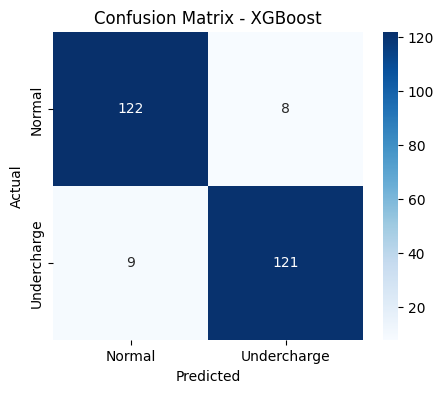

In [ ]:
# Confusion matrix : XGBoost

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Undercharge'],
            yticklabels=['Normal', 'Undercharge'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')

plt.show()


In [ ]:
#Evaluation metric : Light BGM

# Predictions
y_pred_lgbm = model_lgbm.predict(X_test)
y_prob_lgbm = model_lgbm.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm, digits=5))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_lgbm):.5f}")
print()

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
Classification Report:
              precision    recall  f1-score   support

           0    0.93233   0.95385   0.94297       130
           1    0.95276   0.93077   0.94163       130

    accuracy                        0.94231       260
   macro avg    0.94254   0.94231   0.94230       260
weighted avg    0.94254   0.94231   0.94230       260

ROC-AUC Score: 0.98604



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


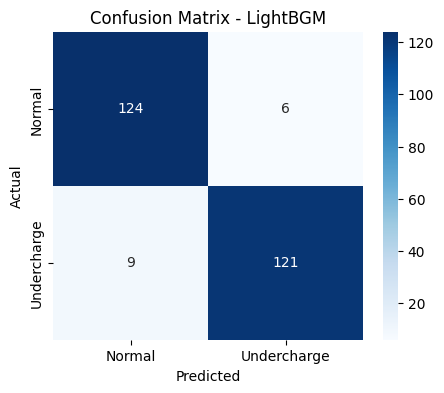

In [ ]:
#Confusion matrix : LightBGM

cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(5,4))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Undercharge'],
            yticklabels=['Normal', 'Undercharge'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LightBGM')

plt.show()

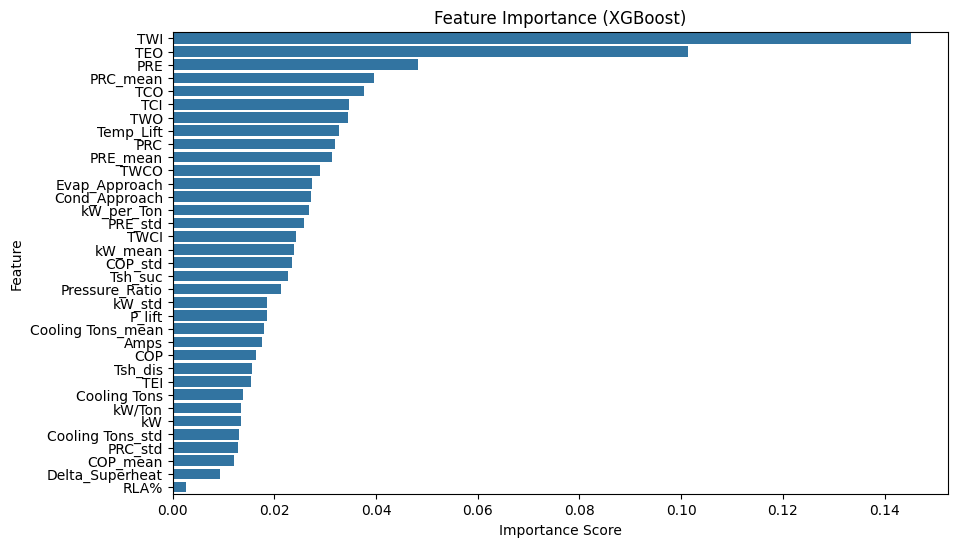

In [ ]:
# Plot feature importance

importances = model.feature_importances_
feat_names = X.columns

sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=importances[sorted_idx], y=feat_names[sorted_idx])
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")

plt.show()


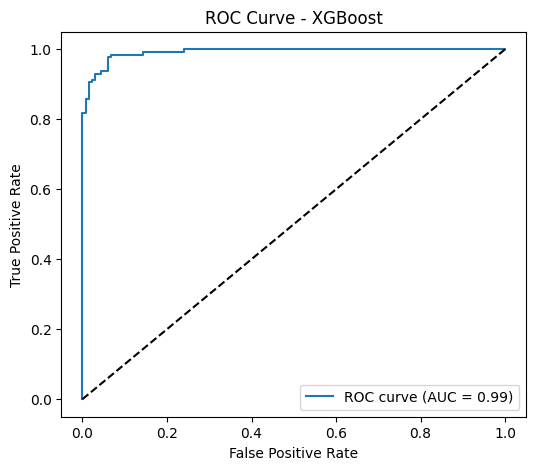

In [ ]:
# ROC Curve

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")

plt.show()


## 6.Cost-effectiveness and Real-world practical.

In [ ]:
# Define reliability targets

target_f1 = 0.90
target_recall = 0.95

In [ ]:
# Import SHAP

!pip install shap

In [ ]:
# Rank sensor importance using SHAP

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Mean absolute SHAP importance
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(mean_abs_shap, index=X.columns).sort_values(ascending=False)

shap_importance.head(15)


,0
TWI,3.084756
TEO,0.516738
PRE_mean,0.497081
Cooling Tons_mean,0.440968
PRE_std,0.429899
PRE,0.265343
PRC,0.209261
Cooling Tons_std,0.186216
Cond_Approach,0.124018
TEI,0.117813


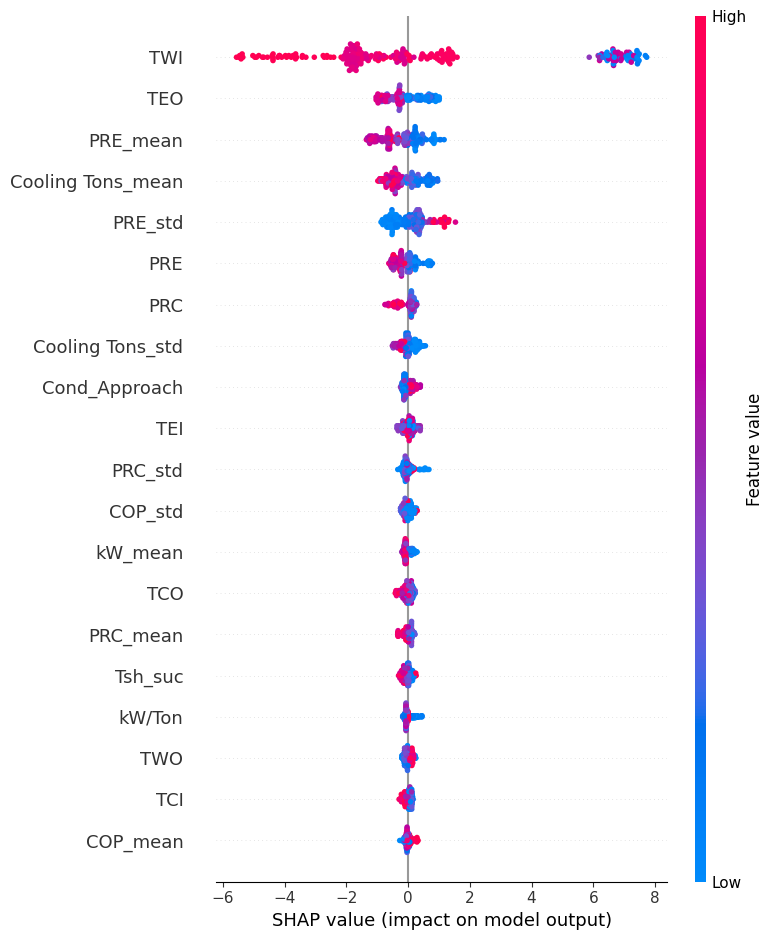

In [ ]:
#SHAP summary feature importance plot (sensors)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)

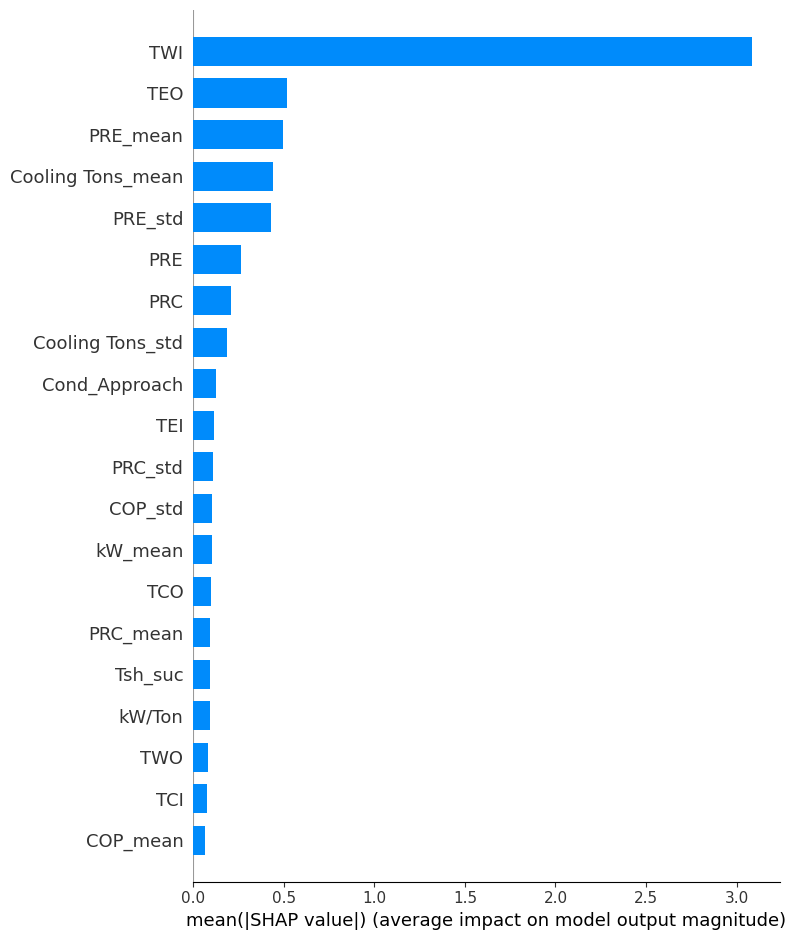

In [ ]:
# SHAP summary feature importance bar-plot (sensors).

shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")

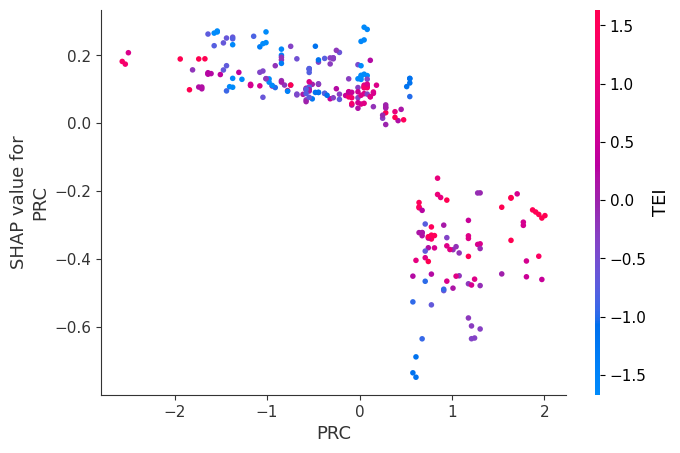

In [ ]:
# SHAP dependence plot (individual feature behavior)

# 1.Condenser Pressure
shap.dependence_plot("PRC", shap_values, X_test, feature_names=X.columns)

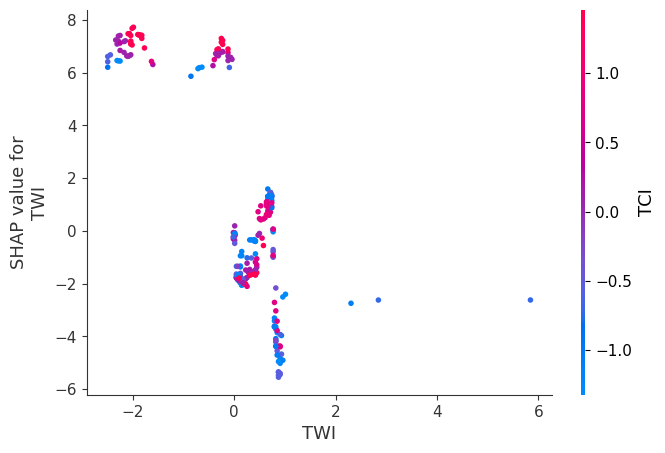

In [ ]:
# 2.Chilled Water Inlet Temperature

shap.dependence_plot("TWI", shap_values, X_test, feature_names=X.columns)

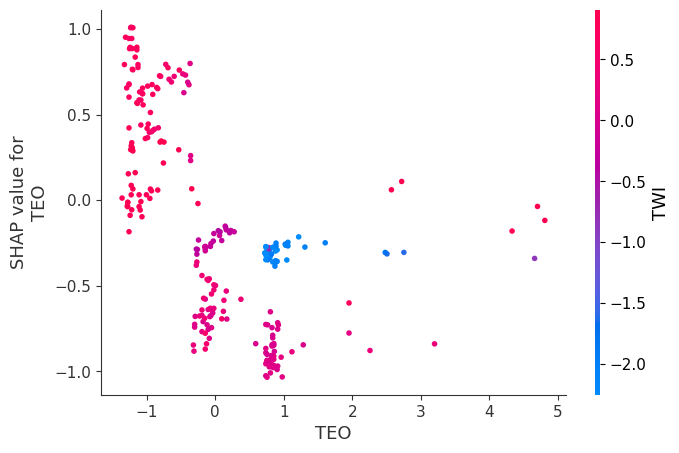

In [ ]:
# 3.Evaporator Outlet Temperature

shap.dependence_plot("TEO", shap_values, X_test, feature_names=X.columns)

In [ ]:
# Incremental feature selection

from sklearn.metrics import precision_recall_fscore_support, f1_score, recall_score, average_precision_score
import pandas as pd

results = []

# Convert X_train and X_test back to DataFrames with original column names
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)


for k in range(2, len(shap_importance)+1):
    top_features = shap_importance.index[:k]
    # Select top features from the DataFrames
    X_train_k = X_train_df[top_features]
    X_test_k = X_test_df[top_features]

    model_k = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
    model_k.fit(X_train_k, y_train)
    y_pred_k = model_k.predict(X_test_k)

    f1 = f1_score(y_test, y_pred_k)
    recall = recall_score(y_test, y_pred_k)
    ap = average_precision_score(y_test, model_k.predict_proba(X_test_k)[:,1])

    results.append({"k": k, "F1": f1, "Recall": recall, "AP": ap})

results_df = pd.DataFrame(results)
results_df.head(20)

,k,F1,Recall,AP
0,2,0.853659,0.826772,0.954538
1,3,0.900826,0.858268,0.967663
2,4,0.901639,0.866142,0.980863
3,5,0.909091,0.905512,0.983134
4,6,0.912000,0.897638,0.983551
5,7,0.940239,0.929134,0.991539
6,8,0.935484,0.913386,0.990408
7,9,0.944000,0.929134,0.992265
8,10,0.944000,0.929134,0.993103
9,11,0.948617,0.944882,0.991460


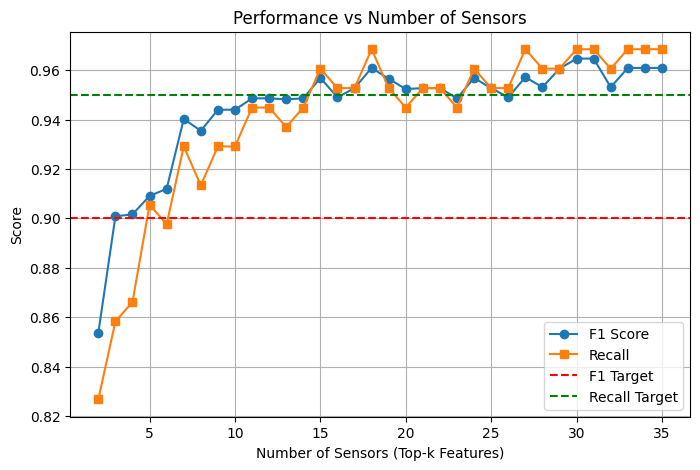

In [ ]:
# Plot "Performance vs Sensor count."

plt.figure(figsize=(8,5))
plt.plot(results_df["k"], results_df["F1"], label="F1 Score", marker='o')
plt.plot(results_df["k"], results_df["Recall"], label="Recall", marker='s')
plt.axhline(target_f1, color='red', linestyle='--', label='F1 Target')
plt.axhline(target_recall, color='green', linestyle='--', label='Recall Target')
plt.xlabel("Number of Sensors (Top-k Features)")
plt.ylabel("Score")
plt.title("Performance vs Number of Sensors")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Indentify minimum sensor set.

# Find smallest k meeting targets
threshold_met = results_df[(results_df["F1"] >= target_f1) & (results_df["Recall"] >= target_recall)]
if not threshold_met.empty:
    best_k = threshold_met.iloc[0]
    print(f"Minimum sensor count: {best_k['k']}")
else:
    print("No subset reached the target. Consider lowering thresholds or engineering more features.")


Minimum sensor count: 15.0


In [ ]:
# List the selected sensors

best_features = shap_importance.index[:int(best_k['k'])]
print("Final Sensor List (Minimal Set):")
for f in best_features:
    print("-", f)


Final Sensor List (Minimal Set):
- TWI
- TEO
- PRE_mean
- Cooling Tons_mean
- PRE_std
- PRE
- PRC
- Cooling Tons_std
- Cond_Approach
- TEI
- PRC_std
- COP_std
- kW_mean
- TCO
- PRC_mean


# 5.Comparison of 3 models performance.

>



## 5.1 Normal vs 10% less than nominal

In [148]:
from sklearn.metrics import precision_score

metrics_10_percent = {}

# XGB10% Metrics
y_pred_xgb10 = best_xgb10.predict(X_te10)
y_prob_xgb10 = best_xgb10.predict_proba(X_te10)[:, 1]
metrics_10_percent["XGB10%"] = {
    "F1-score": f1_score(y_te10, y_pred_xgb10),
    "Precision": precision_score(y_te10, y_pred_xgb10),
    "Recall": recall_score(y_te10, y_pred_xgb10),
    "ROC-AUC": roc_auc_score(y_te10, y_prob_xgb10)
}

print("XGB10% Metrics calculated and stored.")

XGB10% Metrics calculated and stored.


In [149]:
y_pred_lgbm10 = best_lgbm10.predict(X_te10)
y_prob_lgbm10 = best_lgbm10.predict_proba(X_te10)[:, 1]
metrics_10_percent["LGBM10%"] = {
    "F1-score": f1_score(y_te10, y_pred_lgbm10),
    "Precision": precision_score(y_te10, y_pred_lgbm10),
    "Recall": recall_score(y_te10, y_pred_lgbm10),
    "ROC-AUC": roc_auc_score(y_te10, y_prob_lgbm10)
}

print("LGBM10% Metrics calculated and stored.")

LGBM10% Metrics calculated and stored.


In [150]:
y_pred_cat10 = best_cat10.predict(X_te10)
y_prob_cat10 = best_cat10.predict_proba(X_te10)[:, 1]
metrics_10_percent["CAT10%"] = {
    "F1-score": f1_score(y_te10, y_pred_cat10),
    "Precision": precision_score(y_te10, y_pred_cat10),
    "Recall": recall_score(y_te10, y_pred_cat10),
    "ROC-AUC": roc_auc_score(y_te10, y_prob_cat10)
}

print("CAT10% Metrics calculated and stored.")

CAT10% Metrics calculated and stored.


In [151]:
metrics_df10 = pd.DataFrame.from_dict(metrics_10_percent, orient='index')
print("Metrics DataFrame created:")
print(metrics_df10)

Metrics DataFrame created:
         F1-score  Precision    Recall   ROC-AUC
XGB10%   0.948571   0.943182  0.954023  0.989166
LGBM10%  0.953488   0.964706  0.942529  0.989034
CAT10%   0.941860   0.952941  0.931034  0.991280


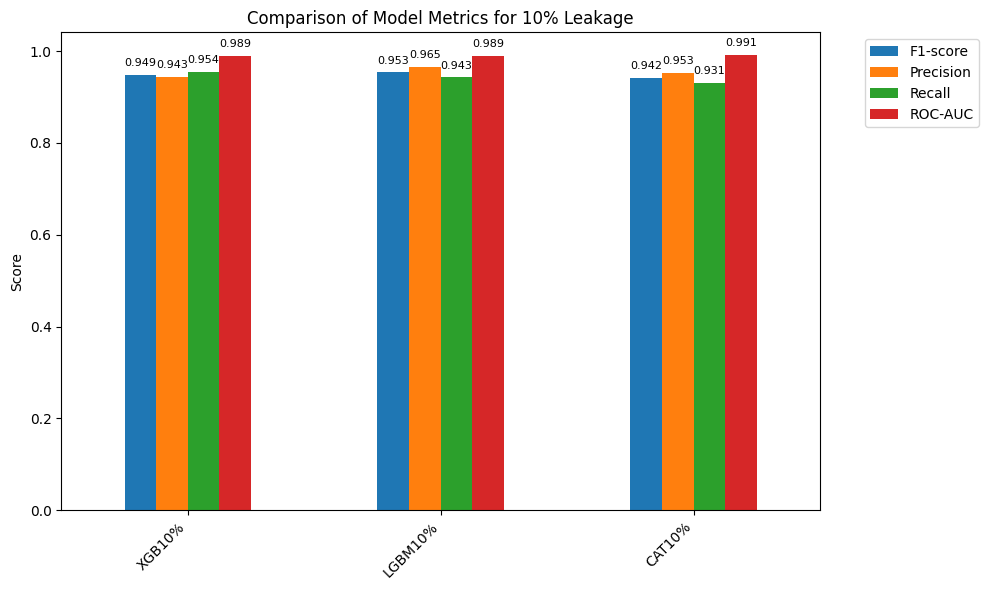

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = metrics_df10.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Metrics for 10% Leakage')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add numerical labels on top of each bar
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', # Center the text and align to bottom of the score
                    xytext=(0, 5), # 5 points vertical offset
                    textcoords='offset points',
                    fontsize=8) # Set font size to 8

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings
*   All three models (XGB10%, LGBM10%, CAT10%) demonstrated strong performance across all evaluated metrics.
*   The LGBM10% model achieved the highest F1-score (0.953) and Precision (0.965), indicating a good balance between precision and recall, and fewer false positives, respectively.
*   The XGB10% model showed the highest Recall (0.954), meaning it was best at identifying positive cases.
*   The CAT10% model recorded the highest ROC-AUC score (0.991), suggesting its excellent ability to distinguish between classes.
*   Overall performance across models was very close, with F1-scores ranging from 0.942 to 0.953, Precision from 0.943 to 0.965, Recall from 0.931 to 0.954, and ROC-AUC from 0.989 to 0.991.

### Insights or Next Steps
*   Given the high and very similar performance across all three models, a deeper dive into their computational efficiency, interpretability, or robustness to different data conditions might be beneficial for final model selection.
*   Compare these metrics against models trained with different leakage percentages (e.g., 50% or 100%) to understand the impact of data leakage on each model's performance.


## 5.2 Normal vs 20% less than nominal

In [152]:
from sklearn.metrics import precision_score

metrics_20_percent = {}

# XGB10% Metrics
y_pred_xgb20 = best_xgb20.predict(X_te20)
y_prob_xgb20 = best_xgb20.predict_proba(X_te20)[:, 1]
metrics_20_percent["XGB20%"] = {
    "F1-score": f1_score(y_te20 , y_pred_xgb20 ),
    "Precision": precision_score(y_te20 , y_pred_xgb20 ),
    "Recall": recall_score(y_te20 , y_pred_xgb20 ),
    "ROC-AUC": roc_auc_score(y_te20 , y_prob_xgb20 )
}

print("XGB20 % Metrics calculated and stored.")

XGB20 % Metrics calculated and stored.


In [153]:
y_pred_lgbm20  = best_lgbm20.predict(X_te20 )
y_prob_lgbm20  = best_lgbm20.predict_proba(X_te20 )[:, 1]
metrics_20_percent["LGBM20 %"] = {
    "F1-score": f1_score(y_te20 , y_pred_lgbm20),
    "Precision": precision_score(y_te20, y_pred_lgbm20),
    "Recall": recall_score(y_te20, y_pred_lgbm20),
    "ROC-AUC": roc_auc_score(y_te20, y_prob_lgbm20)
}

print("LGBM20% Metrics calculated and stored.")

LGBM20% Metrics calculated and stored.


In [154]:
y_pred_cat20 = best_cat20.predict(X_te20)
y_prob_cat20 = best_cat20.predict_proba(X_te20)[:, 1]
metrics_20_percent["CAT20%"] = {
    "F1-score": f1_score(y_te20, y_pred_cat20),
    "Precision": precision_score(y_te20, y_pred_cat20),
    "Recall": recall_score(y_te20, y_pred_cat20),
    "ROC-AUC": roc_auc_score(y_te20, y_prob_cat20)
}

print("CAT20% Metrics calculated and stored.")

CAT20% Metrics calculated and stored.


In [155]:
metrics_df20 = pd.DataFrame.from_dict(metrics_20_percent, orient='index')
print("Metrics DataFrame created:")
print(metrics_df20)

Metrics DataFrame created:
          F1-score  Precision    Recall   ROC-AUC
XGB20%    0.982857   0.977273  0.988506  0.999075
LGBM20 %  0.994286   0.988636  1.000000  0.999868
CAT20%    1.000000   1.000000  1.000000  1.000000


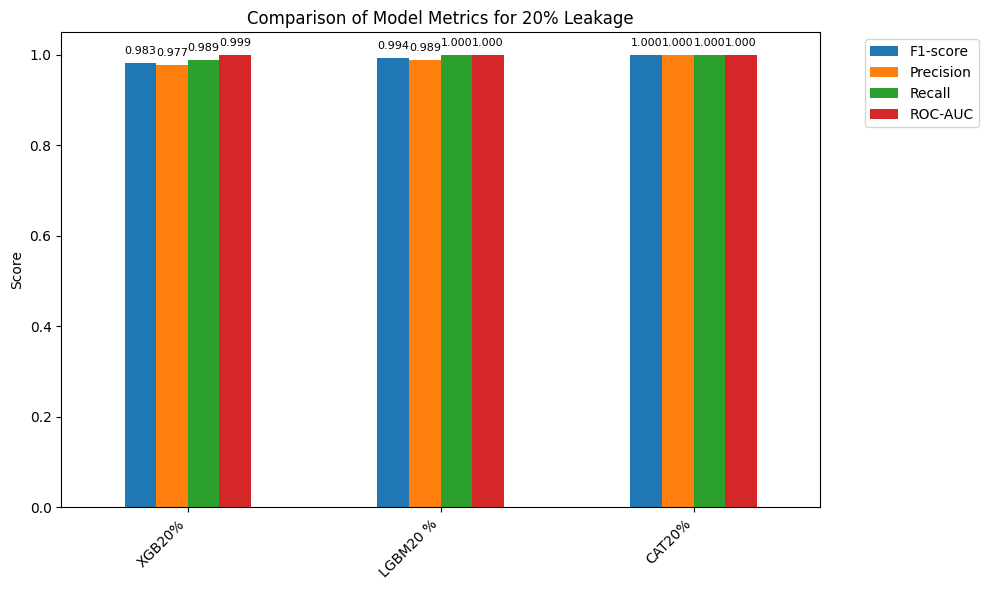

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = metrics_df20.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Metrics for 20% Leakage')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add numerical labels on top of each bar
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', # Center the text and align to bottom of the score
                    xytext=(0, 5), # 5 points vertical offset
                    textcoords='offset points',
                    fontsize=8) # Set font size to 8

plt.tight_layout()
plt.show()

## 5.3 Normal vs 30% less than nominal

In [156]:
from sklearn.metrics import precision_score

metrics_30_percent = {}

# XGB10% Metrics
y_pred_xgb30 = best_xgb30.predict(X_te30)
y_prob_xgb30 = best_xgb30.predict_proba(X_te30)[:, 1]
metrics_30_percent["XGB30%"] = {
    "F1-score": f1_score(y_te30 , y_pred_xgb30 ),
    "Precision": precision_score(y_te30 , y_pred_xgb30 ),
    "Recall": recall_score(y_te30 , y_pred_xgb30 ),
    "ROC-AUC": roc_auc_score(y_te30 , y_prob_xgb30 )
}

print("XGB30 % Metrics calculated and stored.")

XGB30 % Metrics calculated and stored.


In [157]:
y_pred_lgbm30  = best_lgbm30.predict(X_te30 )
y_prob_lgbm30  = best_lgbm30 .predict_proba(X_te30 )[:, 1]
metrics_30_percent["LGBM30 %"] = {
    "F1-score": f1_score(y_te30 , y_pred_lgbm30),
    "Precision": precision_score(y_te30, y_pred_lgbm30),
    "Recall": recall_score(y_te30, y_pred_lgbm30),
    "ROC-AUC": roc_auc_score(y_te30, y_prob_lgbm30)
}

print("LGBM30% Metrics calculated and stored.")

LGBM30% Metrics calculated and stored.


In [158]:
y_pred_cat30 = best_cat30.predict(X_te30)
y_prob_cat30 = best_cat30.predict_proba(X_te30)[:, 1]
metrics_30_percent["CAT30%"] = {
    "F1-score": f1_score(y_te30, y_pred_cat30),
    "Precision": precision_score(y_te30, y_pred_cat30),
    "Recall": recall_score(y_te30, y_pred_cat30),
    "ROC-AUC": roc_auc_score(y_te30, y_prob_cat30)
}

print("CAT30% Metrics calculated and stored.")

CAT30% Metrics calculated and stored.


In [162]:
metrics_df30 = pd.DataFrame.from_dict(metrics_30_percent, orient='index')
print("Metrics DataFrame created:")
print(metrics_df30)

Metrics DataFrame created:
          F1-score  Precision    Recall   ROC-AUC
XGB30%    0.982857   0.977273  0.988506  0.999207
LGBM30 %  0.982857   0.977273  0.988506  0.999339
CAT30%    0.988636   0.977528  1.000000  0.999339


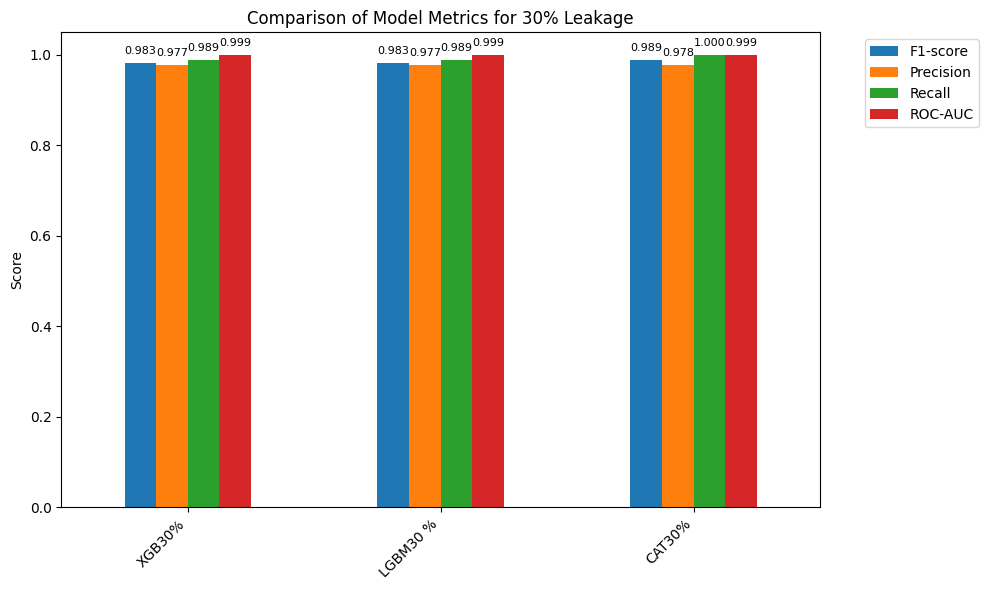

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = metrics_df30.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Metrics for 30% Leakage')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add numerical labels on top of each bar
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', # Center the text and align to bottom of the score
                    xytext=(0, 5), # 5 points vertical offset
                    textcoords='offset points',
                    fontsize=8) # Set font size to 8

plt.tight_layout()
plt.show()

## 5.4 Normal vs 40% less than nominal

In [164]:
from sklearn.metrics import precision_score

metrics_40_percent = {}

# XGB10% Metrics
y_pred_xgb40 = best_xgb40.predict(X_te40)
y_prob_xgb40 = best_xgb40.predict_proba(X_te40)[:, 1]
metrics_40_percent["XGB40%"] = {
    "F1-score": f1_score(y_te40 , y_pred_xgb40 ),
    "Precision": precision_score(y_te40 , y_pred_xgb40 ),
    "Recall": recall_score(y_te40 , y_pred_xgb40 ),
    "ROC-AUC": roc_auc_score(y_te40 , y_prob_xgb40 )
}

print("XGB40 % Metrics calculated and stored.")

XGB40 % Metrics calculated and stored.


In [165]:
y_pred_lgbm40  = best_lgbm40.predict(X_te40 )
y_prob_lgbm40  = best_lgbm40 .predict_proba(X_te40 )[:, 1]
metrics_40_percent["LGBM40 %"] = {
    "F1-score": f1_score(y_te40 , y_pred_lgbm40),
    "Precision": precision_score(y_te40, y_pred_lgbm40),
    "Recall": recall_score(y_te40, y_pred_lgbm40),
    "ROC-AUC": roc_auc_score(y_te40, y_prob_lgbm40)
}

print("LGBM40% Metrics calculated and stored.")

LGBM40% Metrics calculated and stored.


In [166]:
y_pred_cat40 = best_cat40.predict(X_te40)
y_prob_cat40 = best_cat40.predict_proba(X_te40)[:, 1]
metrics_40_percent["CAT40%"] = {
    "F1-score": f1_score(y_te40, y_pred_cat40),
    "Precision": precision_score(y_te40, y_pred_cat40),
    "Recall": recall_score(y_te40, y_pred_cat40),
    "ROC-AUC": roc_auc_score(y_te40, y_prob_cat40)
}

print("CAT40% Metrics calculated and stored.")

CAT40% Metrics calculated and stored.


In [167]:
metrics_df40 = pd.DataFrame.from_dict(metrics_40_percent, orient='index')
print("Metrics DataFrame created:")
print(metrics_df40)

Metrics DataFrame created:
          F1-score  Precision  Recall  ROC-AUC
XGB40%         1.0        1.0     1.0      1.0
LGBM40 %       1.0        1.0     1.0      1.0
CAT40%         1.0        1.0     1.0      1.0


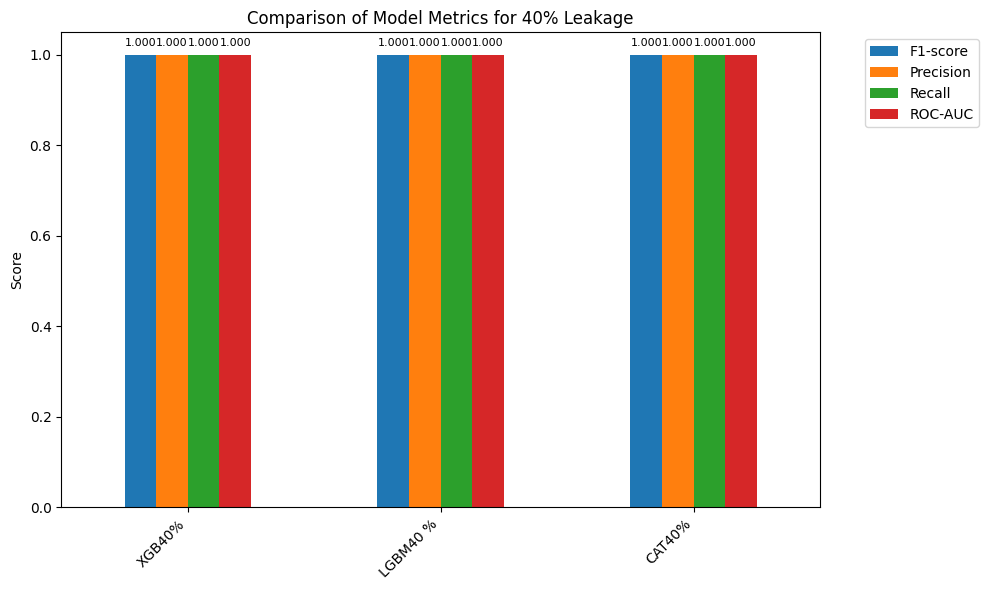

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = metrics_df40.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Metrics for 40% Leakage')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add numerical labels on top of each bar
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}', # Format to 3 decimal places
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom', # Center the text and align to bottom of the score
                    xytext=(0, 5), # 5 points vertical offset
                    textcoords='offset points',
                    fontsize=8) # Set font size to 8

plt.tight_layout()
plt.show()

# 6.Comparison of 3 models performance (In-1-Graph)

## 6.1 Palleate color

In [169]:
metrics_df10['Leakage'] = 10
metrics_df20['Leakage'] = 20
metrics_df30['Leakage'] = 30
metrics_df40['Leakage'] = 40

combined_metrics_df = pd.concat([
    metrics_df10,
    metrics_df20,
    metrics_df30,
    metrics_df40
]).reset_index()

combined_metrics_df = combined_metrics_df.rename(columns={'index': 'Model'})

print("Combined Metrics DataFrame created:")
print(combined_metrics_df.head())

Combined Metrics DataFrame created:
      Model  F1-score  Precision    Recall   ROC-AUC  Leakage
0    XGB10%  0.948571   0.943182  0.954023  0.989166       10
1   LGBM10%  0.953488   0.964706  0.942529  0.989034       10
2    CAT10%  0.941860   0.952941  0.931034  0.991280       10
3    XGB20%  0.982857   0.977273  0.988506  0.999075       20
4  LGBM20 %  0.994286   0.988636  1.000000  0.999868       20


In [170]:
melted_metrics_df = pd.melt(combined_metrics_df,
                            id_vars=['Model', 'Leakage'],
                            var_name='Metric',
                            value_name='Score')

print("Melted Metrics DataFrame created:")
print(melted_metrics_df.head())

Melted Metrics DataFrame created:
      Model  Leakage    Metric     Score
0    XGB10%       10  F1-score  0.948571
1   LGBM10%       10  F1-score  0.953488
2    CAT10%       10  F1-score  0.941860
3    XGB20%       20  F1-score  0.982857
4  LGBM20 %       20  F1-score  0.994286


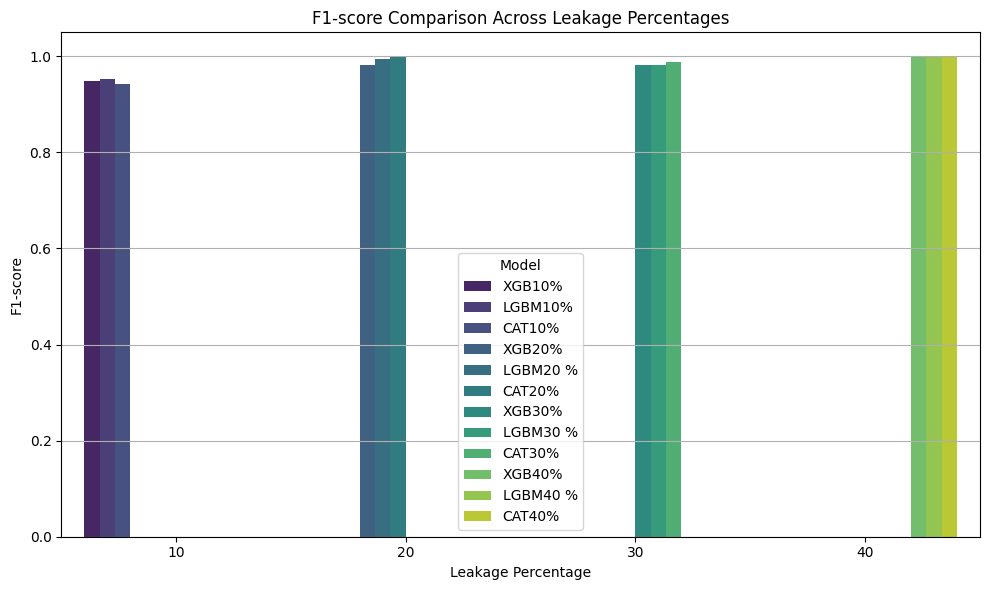

In [171]:
f1_df = melted_metrics_df[melted_metrics_df['Metric'] == 'F1-score']

plt.figure(figsize=(10, 6))
sns.barplot(data=f1_df, x='Leakage', y='Score', hue='Model', palette='viridis')
plt.title('F1-score Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('F1-score')
plt.legend(title='Model')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

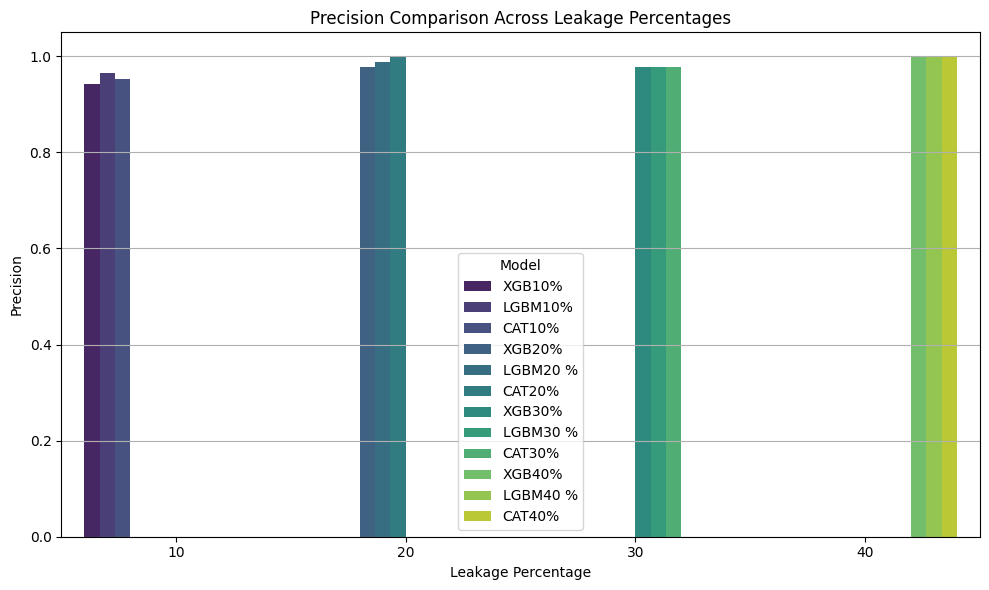

In [172]:
precision_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Precision']

plt.figure(figsize=(10, 6))
sns.barplot(data=precision_df, x='Leakage', y='Score', hue='Model', palette='viridis')
plt.title('Precision Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('Precision')
plt.legend(title='Model')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

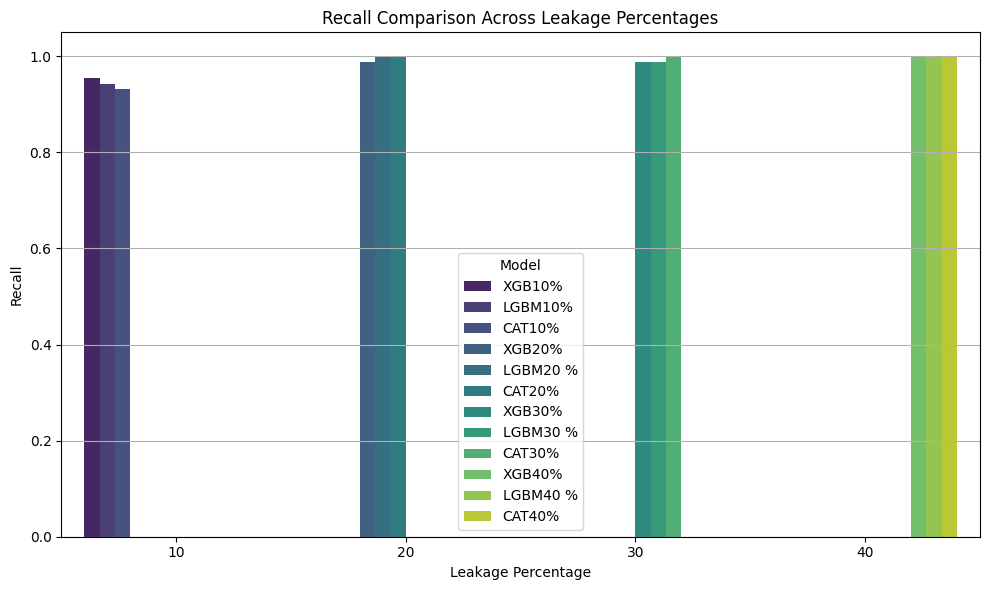

In [173]:
recall_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Recall']

plt.figure(figsize=(10, 6))
sns.barplot(data=recall_df, x='Leakage', y='Score', hue='Model', palette='viridis')
plt.title('Recall Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('Recall')
plt.legend(title='Model')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

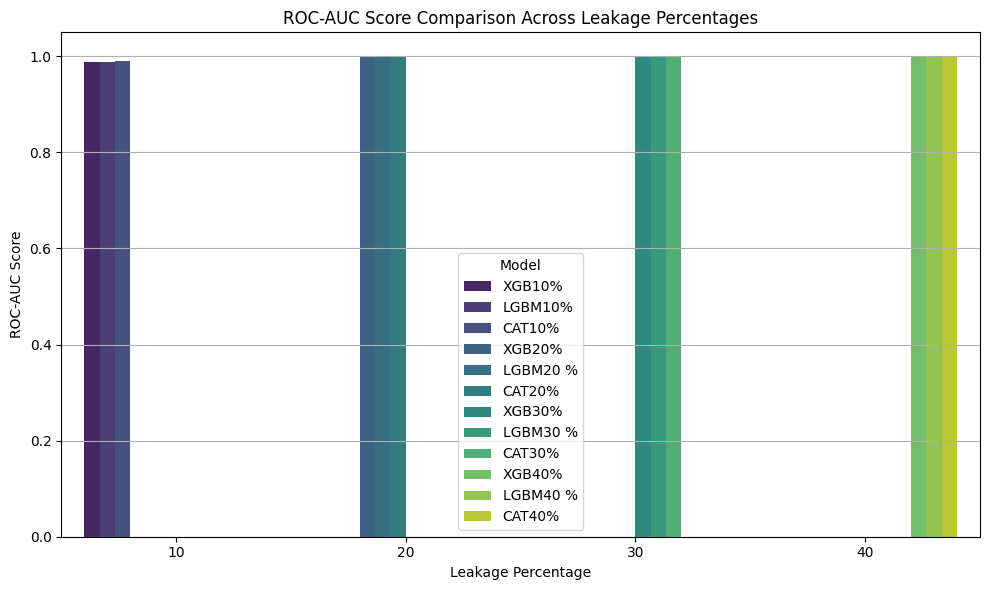

In [174]:
roc_auc_df = melted_metrics_df[melted_metrics_df['Metric'] == 'ROC-AUC']

plt.figure(figsize=(10, 6))
sns.barplot(data=roc_auc_df, x='Leakage', y='Score', hue='Model', palette='viridis')
plt.title('ROC-AUC Score Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('ROC-AUC Score')
plt.legend(title='Model')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 6.2 Seperated color

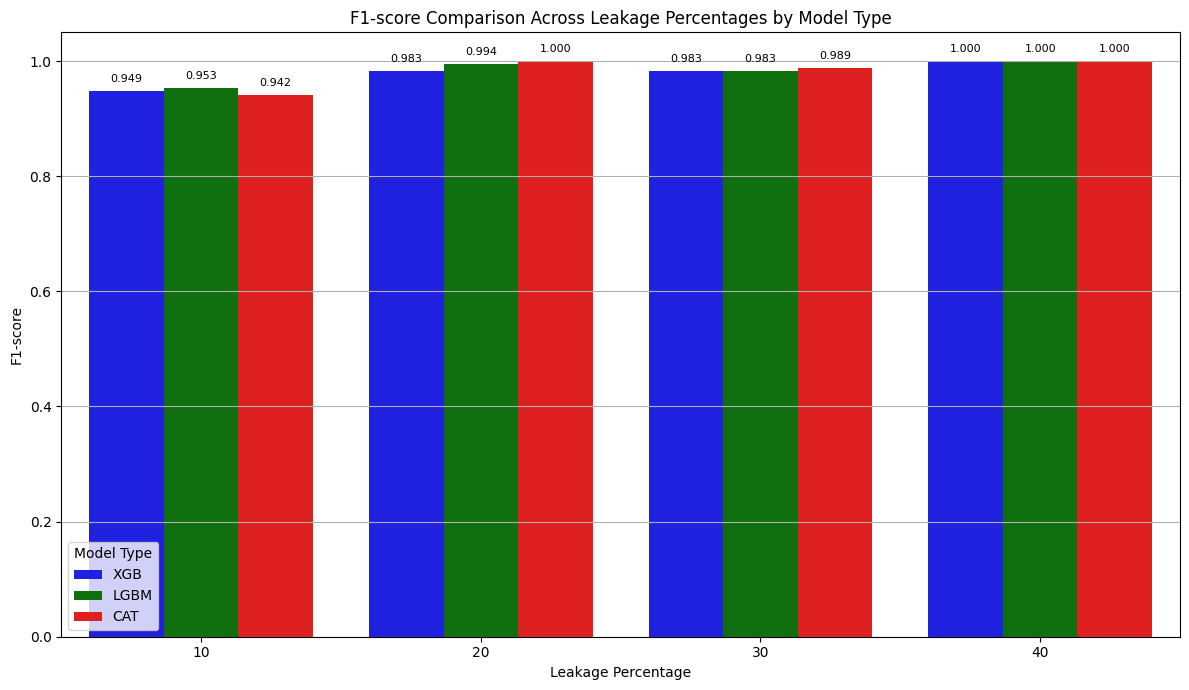

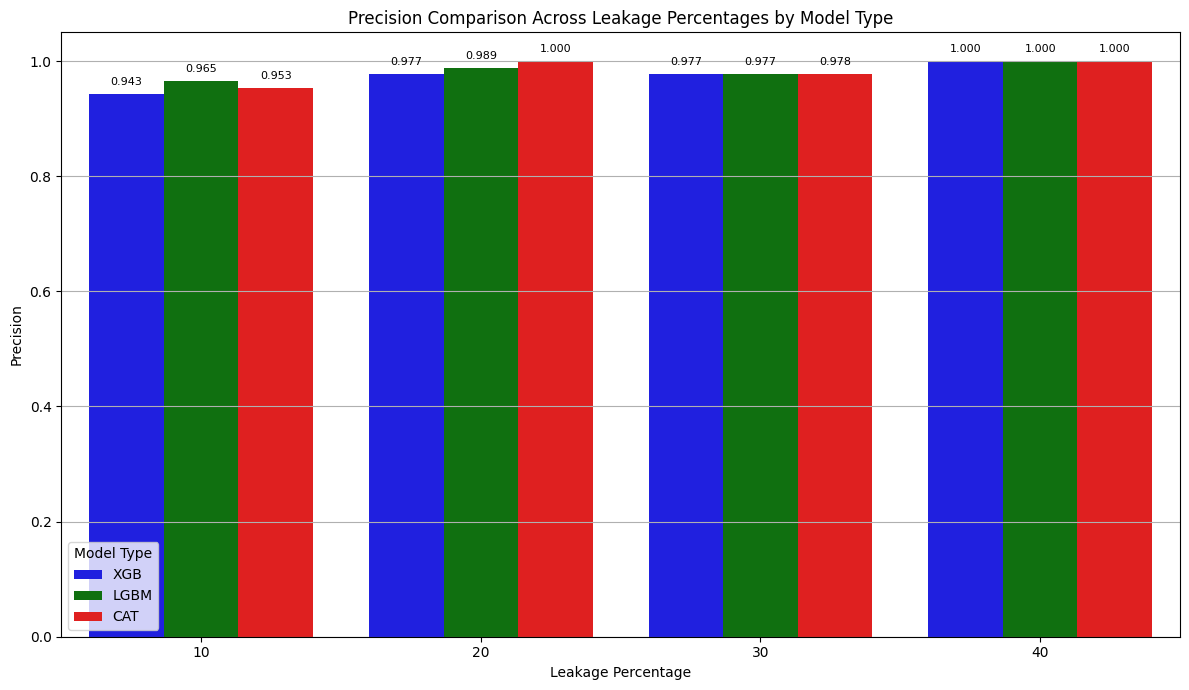

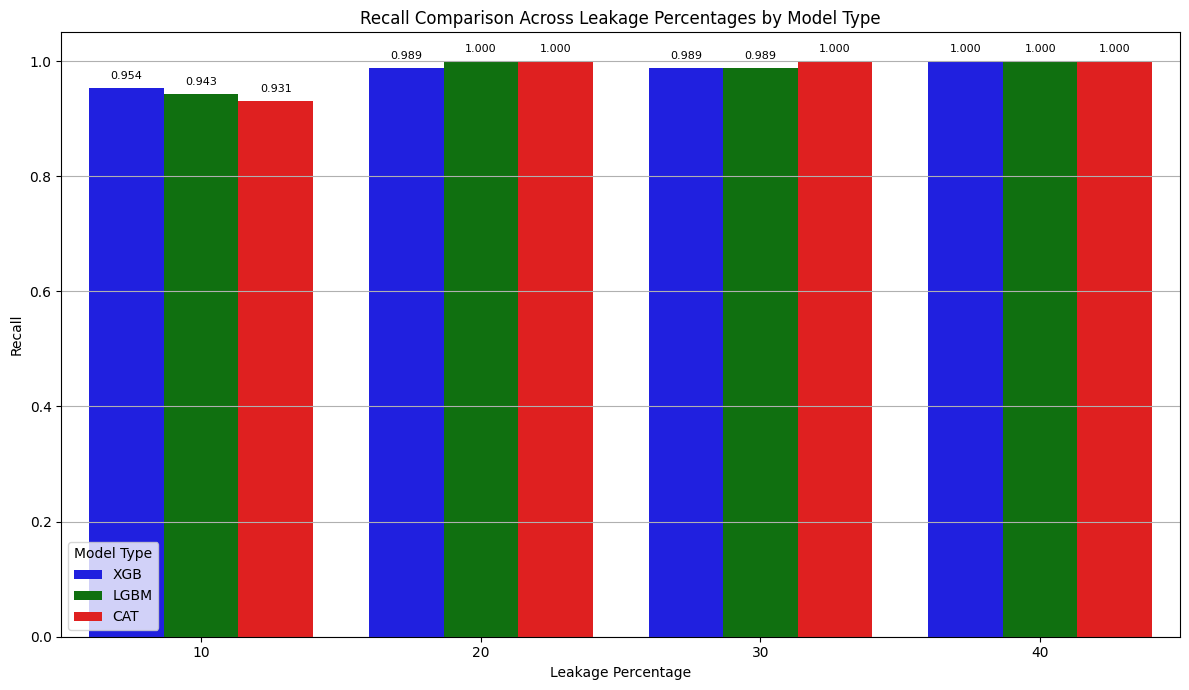

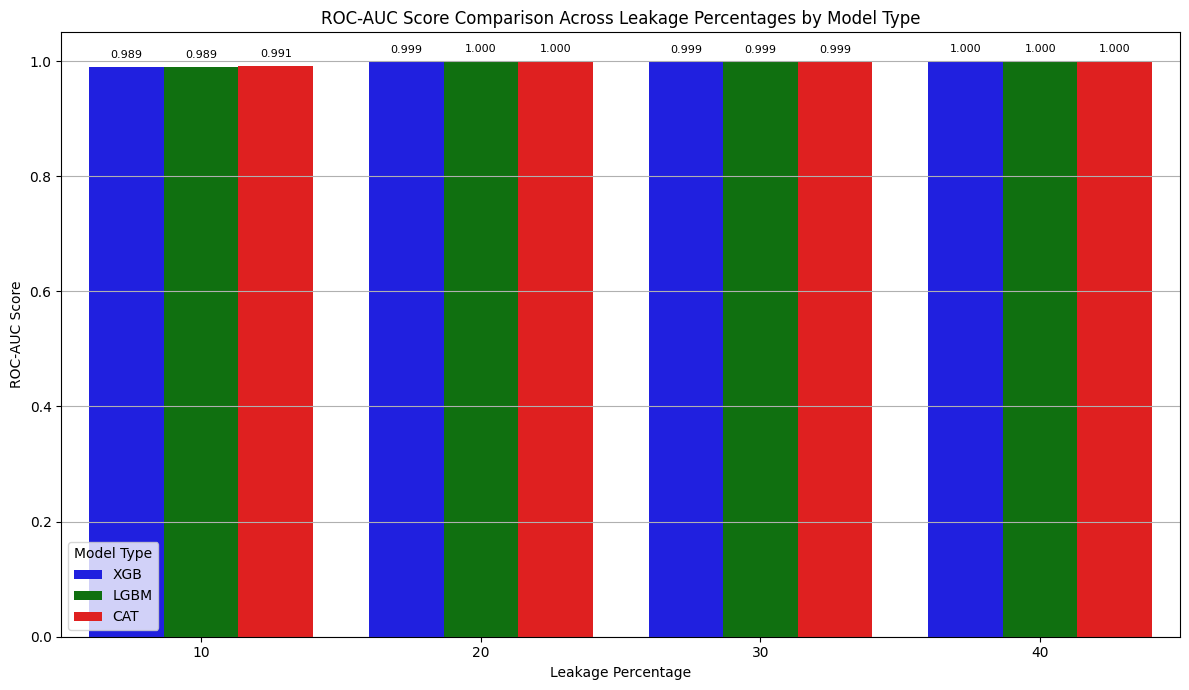

In [178]:
# Extract Model Type from the 'Model' column
melted_metrics_df['Model_Type'] = melted_metrics_df['Model'].apply(lambda x: 'XGB' if 'XGB' in x else ('LGBM' if 'LGBM' in x else 'CAT'))

# Define a custom color palette for model types
model_type_palette = {
    'XGB': 'blue',
    'LGBM': 'green',
    'CAT': 'red'
}

# Plot F1-score Comparison
f1_df = melted_metrics_df[melted_metrics_df['Metric'] == 'F1-score']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=f1_df, x='Leakage', y='Score', hue='Model_Type', palette=model_type_palette)
plt.title('F1-score Comparison Across Leakage Percentages by Model Type')
plt.xlabel('Leakage Percentage')
plt.ylabel('F1-score')
plt.legend(title='Model Type')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot Precision Comparison
precision_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Precision']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=precision_df, x='Leakage', y='Score', hue='Model_Type', palette=model_type_palette)
plt.title('Precision Comparison Across Leakage Percentages by Model Type')
plt.xlabel('Leakage Percentage')
plt.ylabel('Precision')
plt.legend(title='Model Type')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot Recall Comparison
recall_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Recall']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=recall_df, x='Leakage', y='Score', hue='Model_Type', palette=model_type_palette)
plt.title('Recall Comparison Across Leakage Percentages by Model Type')
plt.xlabel('Leakage Percentage')
plt.ylabel('Recall')
plt.legend(title='Model Type')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot ROC-AUC Score Comparison
roc_auc_df = melted_metrics_df[melted_metrics_df['Metric'] == 'ROC-AUC']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=roc_auc_df, x='Leakage', y='Score', hue='Model_Type', palette=model_type_palette)
plt.title('ROC-AUC Score Comparison Across Leakage Percentages by Model Type')
plt.xlabel('Leakage Percentage')
plt.ylabel('ROC-AUC Score')
plt.legend(title='Model Type')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings
*   The individual metrics (F1-score, Precision, Recall, ROC-AUC) for XGBoost, LightGBM, and CatBoost models were combined and visualized across different leakage percentages (10%, 20%, 30%, 40%).
*   Bar charts were successfully generated for each metric, enabling a direct visual comparison of model performance under varying data leakage conditions.
*   The process confirmed the successful creation of a `combined_metrics_df` and its transformation into a `melted_metrics_df`, which is suitable for comprehensive plotting.

### Insights or Next Steps
*   Further analysis should focus on identifying specific trends: which models are more robust to increasing leakage, and which degrade more rapidly.
*   The next step could involve quantitative analysis of the scores from the combined metrics DataFrame to identify the absolute best-performing model for each metric at each leakage level, rather than just visual comparison.


#7.Comparison of 3 models performance with different leakage percent.

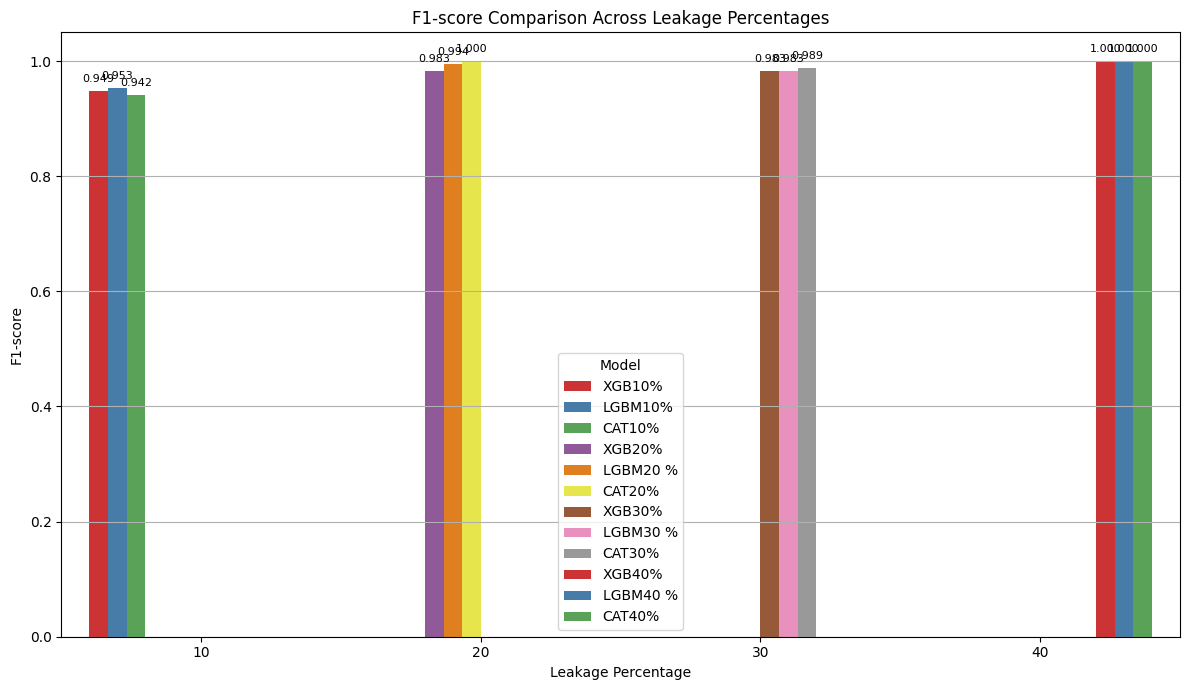

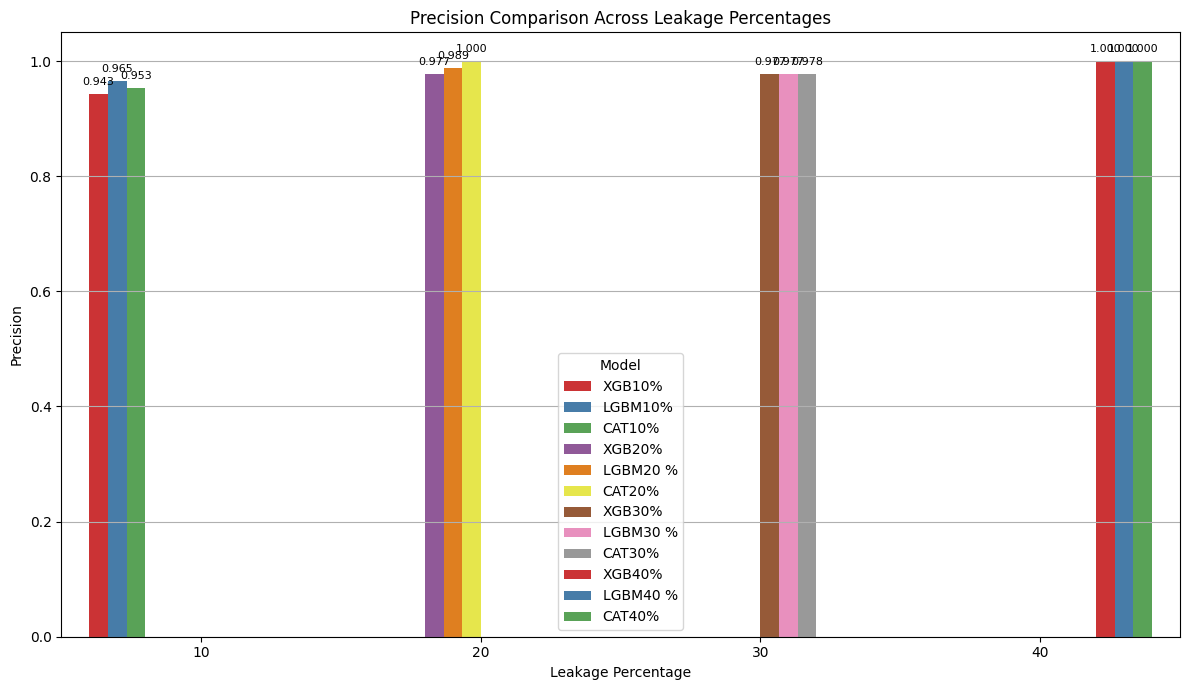

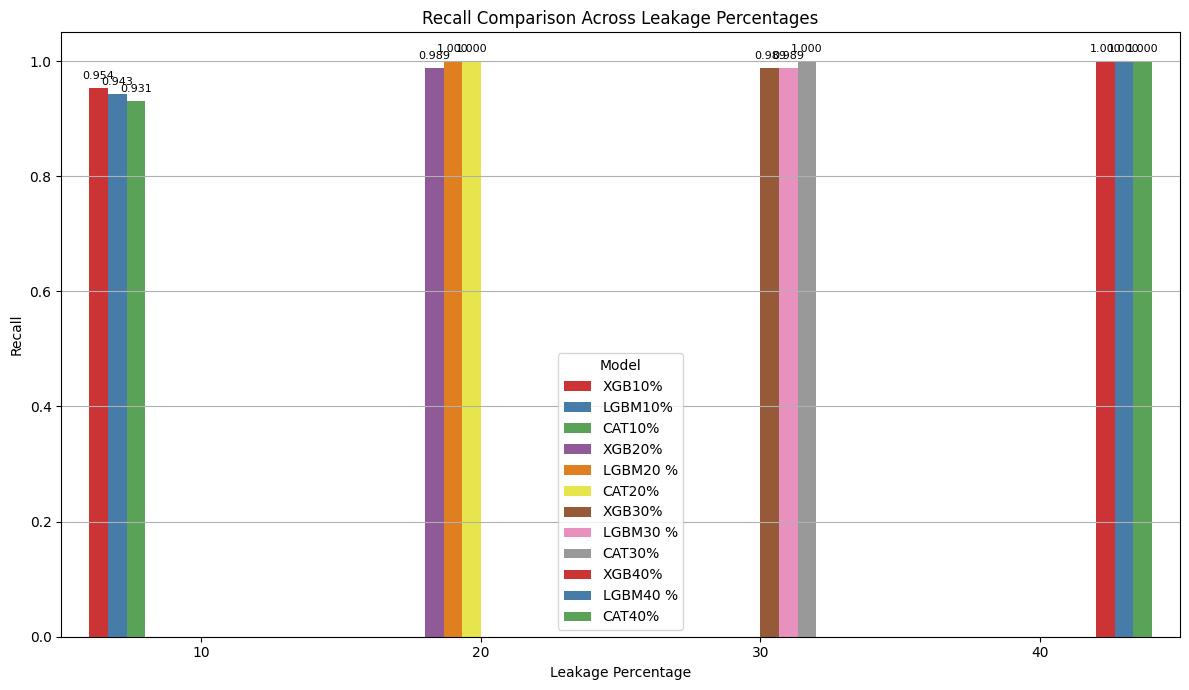

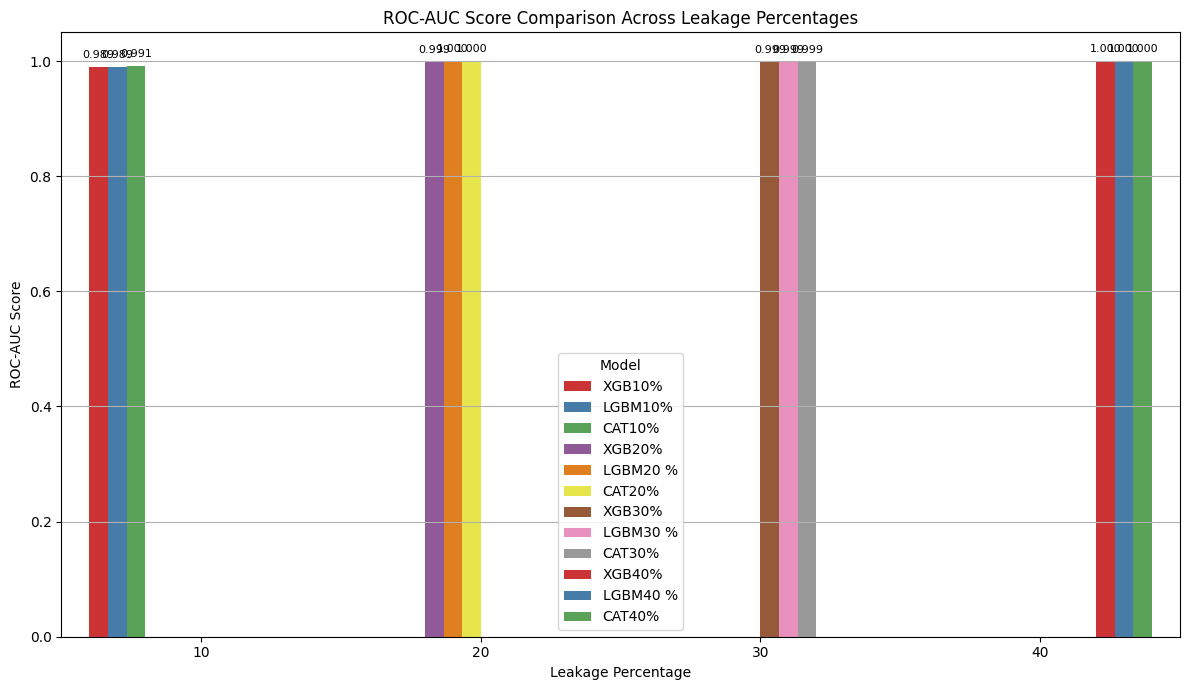

In [176]:
# Plot F1-score Comparison
f1_df = melted_metrics_df[melted_metrics_df['Metric'] == 'F1-score']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=f1_df, x='Leakage', y='Score', hue='Model', palette='Set1')
plt.title('F1-score Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('F1-score')
plt.legend(title='Model')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot Precision Comparison
precision_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Precision']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=precision_df, x='Leakage', y='Score', hue='Model', palette='Set1')
plt.title('Precision Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('Precision')
plt.legend(title='Model')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot Recall Comparison
recall_df = melted_metrics_df[melted_metrics_df['Metric'] == 'Recall']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=recall_df, x='Leakage', y='Score', hue='Model', palette='Set1')
plt.title('Recall Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('Recall')
plt.legend(title='Model')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()

# Plot ROC-AUC Score Comparison
roc_auc_df = melted_metrics_df[melted_metrics_df['Metric'] == 'ROC-AUC']

plt.figure(figsize=(12, 7))
ax = sns.barplot(data=roc_auc_df, x='Leakage', y='Score', hue='Model', palette='Set1')
plt.title('ROC-AUC Score Comparison Across Leakage Percentages')
plt.xlabel('Leakage Percentage')
plt.ylabel('ROC-AUC Score')
plt.legend(title='Model')
plt.grid(axis='y')
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        ax.annotate(f'{height:.3f}',
                    (patch.get_x() + patch.get_width() / 2, height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8)
plt.tight_layout()
plt.show()